# Capstone Project - <i>"He Got Game So Show Him The Money"</i>

### Contents:
#### Part 3:
- [Data Import](#Data-Import)
- [Pre-Modelling](#Pre-Modelling)
- [Encoding](#Encoding)
- [Quick Test Untuned Models](#Quick-Test-Untuned-Models)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)


## Package Import

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping

In [641]:
from joblib import dump
from keras.models import model_from_json

## Data Import

In [119]:
statsdf = pd.read_csv('./Data/stats_cleaned.csv')

## Pre-Modelling

In [120]:
statsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776 entries, 0 to 3775
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           3776 non-null   int64  
 1   player         3776 non-null   object 
 2   pos            3776 non-null   object 
 3   age            3776 non-null   int64  
 4   tm             3776 non-null   object 
 5   g              3776 non-null   float64
 6   gs             3776 non-null   float64
 7   mp             3776 non-null   float64
 8   per            3776 non-null   float64
 9   ts%            3776 non-null   float64
 10  3par           3776 non-null   float64
 11  ftr            3776 non-null   float64
 12  orb%           3776 non-null   float64
 13  drb%           3776 non-null   float64
 14  trb%           3776 non-null   float64
 15  ast%           3776 non-null   float64
 16  stl%           3776 non-null   float64
 17  blk%           3776 non-null   float64
 18  tov%    

In [121]:
statsdf.corr()['salary'].sort_values(ascending=False).head(20)

salary     1.000000
ppg        0.627104
ppg^2      0.621643
ppg fg     0.601006
ppg pts    0.594266
pts        0.580700
fg         0.578700
ws         0.568754
pts fg     0.568734
fg^2       0.568494
2p         0.563424
pts^2      0.563167
fga        0.561991
2pa        0.556706
fta        0.551961
ft         0.551785
vorp       0.529780
drb        0.522937
tov        0.520924
ows        0.520536
Name: salary, dtype: float64

In [122]:
statsdf.corr()['salary'].sort_values().head(20)

year_start   -0.340713
3par         -0.069109
tov%         -0.049262
orb%         -0.038801
stl%          0.003292
height        0.018202
blk%          0.020112
ftr           0.055499
year          0.061742
3p%           0.075700
efg%          0.096267
2p%           0.096524
trb%          0.103565
fg%           0.115111
weight        0.123520
ft%           0.156018
ts%           0.158496
dbpm          0.160467
drb%          0.181897
g             0.270794
Name: salary, dtype: float64

## Encoding

In [298]:
X = pd.get_dummies(statsdf, columns = ['pos'], drop_first = True)
#tested one-hot encoder for 'college' column and results were extremely poor

In [299]:
le = LabelEncoder()
X['college'] = le.fit_transform(X['college'].tolist())

In [300]:
X.columns

Index(['year', 'player', 'age', 'tm', 'g', 'gs', 'mp', 'per', 'ts%', '3par',
       'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%',
       'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp', 'fg', 'fga',
       'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta',
       'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'salary', 'year_start', 'height', 'weight', 'college', 'rpg', 'apg',
       'ppg', 'spg', 'bpg', 'yrs_in_league', 'ppg^2', 'ppg pts', 'ppg fg',
       'pts^2', 'pts fg', 'fg^2', 'pos_C-PF', 'pos_C-SF', 'pos_PF', 'pos_PF-C',
       'pos_PF-SF', 'pos_PG', 'pos_PG-SG', 'pos_SF', 'pos_SF-PF', 'pos_SF-SG',
       'pos_SG', 'pos_SG-PF', 'pos_SG-PG', 'pos_SG-SF'],
      dtype='object')

In [301]:
X.shape

(3776, 80)

## Quick Test Untuned Models

In [302]:
X = X.drop(columns = ['salary', 'player', 'tm'])

In [303]:
y = np.log(statsdf['salary'])

In [304]:
#test size changed to 0.2 as performance was just not good enough at 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [305]:
ss = StandardScaler()

In [306]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Baseline

In [307]:
#Recap baseline salary
statsdf['salary'].mean()

4954967.603548729

In [308]:
baseline = [np.log(statsdf['salary']).mean() for i in range(len(y_test))]

In [309]:
def basecompare(model_preds):
    #baseline RMSE
    base_rmse = (mean_squared_error(y_test, baseline))**0.5
    #Linear Regression RMSE
    test_rmse = (mean_squared_error(y_test, model_preds))**0.5

    print (f'Baseline RMSE is {base_rmse}. \nThis model\'s RMSE is {test_rmse}.')
    print (f'The percentage change is {round((test_rmse-base_rmse)/base_rmse, 3)*100}%')

In [310]:
r2_score(y_test, baseline)

-7.361794090998686e-05

### Linear Regression

In [136]:
lr = LinearRegression()
cross_val_score(lr, X_train_sc, y_train, cv = 5).mean()

0.5674136401187952

In [137]:
lr_model = lr.fit(X_train_sc, y_train)

In [138]:
lr_trainpreds = lr_model.predict(X_train_sc)
lr_testpreds = lr_model.predict(X_test_sc)

In [139]:
print(r2_score(y_train, lr_trainpreds))
print(r2_score(y_test, lr_testpreds))

0.6011020364610982
0.6275126829305059


In [140]:
#Linear Regression compared to baseline RMSE
basecompare(lr_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.72433532219587.
The percentage change is -39.0%


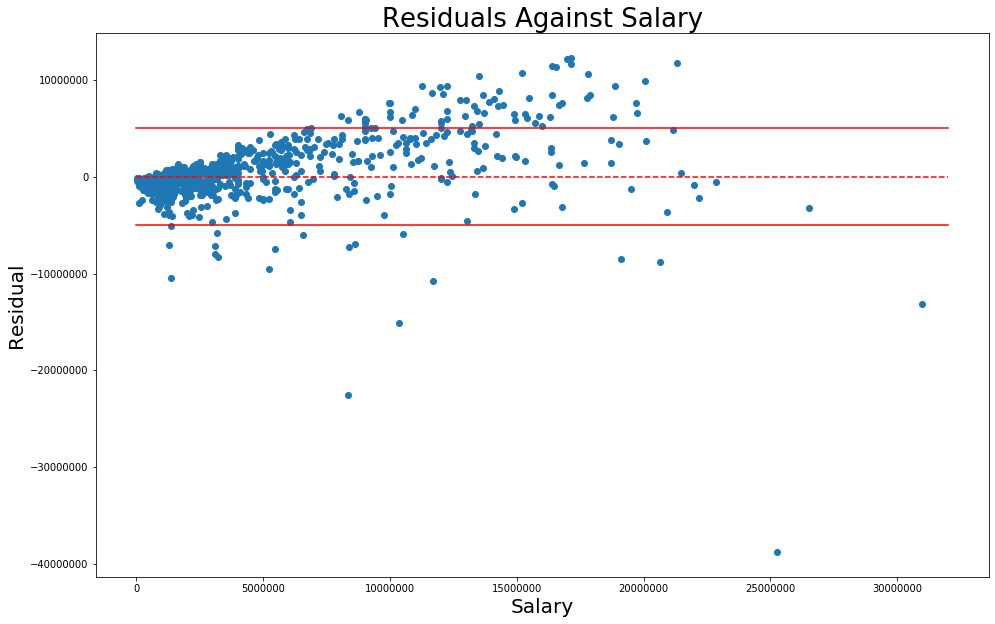

In [141]:
plt.figure(figsize=(16,10))

# Calculate residuals.
#residuals = y_train - lr_trainpreds
residuals2 = (np.exp(y_test) - np.exp(lr_testpreds)) #to convert log values back to normal
#residuals = residuals.append(residuals2)
# Generate scatterplot of residuals.
plt.scatter(np.exp(y_test), residuals2)
# Plot baseline at y=0.
plt.plot((-10,32_000_000),(0,0), color = 'red', linestyle = '--')
plt.plot((-10,32_000_000),(-statsdf['salary'].std(),-statsdf['salary'].std()), color = 'red', linestyle = '-')
plt.plot((-10,32_000_000),(statsdf['salary'].std(),statsdf['salary'].std()), color = 'red', linestyle = '-')

# Set labels and axes.
plt.title("Residuals Against Salary", fontsize=26)
plt.xlabel("Salary", fontsize=20)
plt.ylabel("Residual", fontsize=20)
plt.ticklabel_format(axis = 'both', style = 'plain');

We can see that at the quick-test stage using a simple model has already outperformed the baseline RMSE. r2 for the Linear Regression model is 62% which will only improve with more advanced models. With the large number of variables due to engineering and encoding, it would seem to make sense to use PCA to reduce the number of features.

Let's continue with the remaining base models before implementing decomposition and tuning.

### Ridge Regression

In [142]:
rm = Ridge()
cross_val_score(rm, X_train_sc, y_train, cv = 5).mean()

0.5694271517959407

### Lasso Regression

In [143]:
lm = Lasso()
cross_val_score(lm, X_train_sc, y_train, cv = 5).mean()

-0.0009406005510368409

The Lasso model previously performed similarly to the Ridge model prior to changing the target to log(salary). After the change it no longer appears to be a viable model.

### Random Forest

In [144]:
rf = RandomForestRegressor()
cross_val_score(rf, X_train_sc, y_train, cv = 5).mean()

0.6392121270978863

In [145]:
#the cross val score was quite respectable so let's fit and get an r2 score as a base score to improve upon.
rf_model = rf.fit(X_train_sc, y_train)

In [146]:
rf_trainpreds = rf_model.predict(X_train_sc)
rf_testpreds = rf_model.predict(X_test_sc)

In [147]:
#Linear Regression compared to baseline RMSE
basecompare(rf_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.6758241934867418.
The percentage change is -43.1%


In [148]:
print(r2_score(y_train, rf_trainpreds))
print(r2_score(y_test, rf_testpreds))

0.9504349628775249
0.6757353312477188


### SVR

In [149]:
svr = SVR()
cross_val_score(svr, X_train_sc, y_train, cv = 5).mean()

0.5877159950094943

The SVR model may not perform well on test data with such a low cross val score at base.

## Modelling

### Alpha Search for Ridge and Lasso

In [150]:
alpha_list = np.logspace(0, 10, 200)
ridge_model = RidgeCV(alphas = alpha_list, store_cv_values = True)
ridge_model = ridge_model.fit(X_train_sc, y_train)
print(ridge_model.alpha_)


51.11433483440168


In [151]:
lasso_alpha_list = np.arange(0.001, 0.15, 0.0025)
lasso_model = LassoCV(alphas = alpha_list, max_iter = 10000)
lasso_model = lasso_model.fit(X_train_sc, y_train)
print(lasso_model.alpha_)

10000000000.0


In [152]:
# Define function for easy calling of models
def gsfittrain(gsnum):
    gsnum.fit(X_train_sc, y_train)
    gsnum_model = gsnum.best_estimator_
    print (gsnum.best_score_)
    print (gsnum.best_params_)
    return gsnum_model

### Ridge

In [153]:
pipe1 = Pipeline([('pca', PCA()),
                 ('ridge', Ridge())])

pipe1_params = {
                'pca__n_components' : [10, 20, 50, 60],
                'ridge__alpha' : [ridge_model.alpha_]
                }

gs1 = GridSearchCV(pipe1,
                  param_grid = pipe1_params,
                  cv = 5
                  )

r_model = gsfittrain(gs1)

0.5737243200156177
{'pca__n_components': 50, 'ridge__alpha': 51.11433483440168}


In [154]:
r_trainpreds = r_model.predict(X_train_sc)
r_testpreds = r_model.predict(X_test_sc)

In [155]:
#Ridge Regression compared to baseline RMSE
basecompare(r_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.7278371025100889.
The percentage change is -38.7%


In [156]:
print(r2_score(y_train, r_trainpreds))
print(r2_score(y_test, r_testpreds))

0.5963062621575481
0.6239024165729596


### Lasso

In [157]:
pipe2 = Pipeline([('pca', PCA()),
                 ('lasso', Lasso())])

pipe2_params = {
                'pca__n_components' : [10, 20, 50, 60],
                'lasso__alpha' : [lasso_model.alpha_]
                }

gs2 = GridSearchCV(pipe2,
                  param_grid = pipe2_params,
                  cv = 5
                  )

l_model = gsfittrain(gs2)

-0.0009406005510368409
{'lasso__alpha': 10000000000.0, 'pca__n_components': 10}


In [158]:
l_trainpreds = l_model.predict(X_train_sc)
l_testpreds = l_model.predict(X_test_sc)

In [159]:
#Lasso Regression compared to baseline RMSE
basecompare(l_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 1.1868857316781118.
The percentage change is 0.0%


In [160]:
print(r2_score(y_train, l_trainpreds))
print(r2_score(y_test, l_testpreds))

0.0
-0.00011508898274814605


As expected, with the target changed to log(salary), the Lasso model no longer works.

### Random Forest

In [161]:
pipe3 = Pipeline([('pca', PCA()),
                 ('rf', RandomForestRegressor())])

pipe3_params = {
                'pca__n_components' : [10, 20, 60, None],
                'rf__n_estimators' : [50, 100, 200, 400, 500],
                'rf__min_samples_leaf' : [1, 2, 4],
                'rf__min_samples_split' : [2, 5, 10],
                'rf__max_features' : ['auto', 'sqrt'],
                'rf__max_depth' : [10, 25, 50, None]
                }

gs3 = RandomizedSearchCV(pipe3,
                         param_distributions = pipe3_params,
                         n_iter = 100,
                         cv = 5
                        )

rf_model = gsfittrain(gs3)

0.5791820716627991
{'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'auto', 'rf__max_depth': 25, 'pca__n_components': 60}


In [162]:
rf_trainpreds = rf_model.predict(X_train_sc)
rf_testpreds = rf_model.predict(X_test_sc)

In [163]:
#Random Forest Regression compared to baseline RMSE
basecompare(rf_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.7475751419932717.
The percentage change is -37.0%


In [164]:
print(r2_score(y_train, rf_trainpreds))
print(r2_score(y_test, rf_testpreds))

0.9304564039189878
0.6032272242306057


### Bagging

With the Random Forest overfitting, I decided to add a Bagging Regressor to see if I can reduce the overfit.

In [366]:
pipe4 = Pipeline([('pca', PCA()),
                 ('bag', BaggingRegressor())])

pipe4_params = {
                'pca__n_components' : [10, 20, 60, None],
                'bag__n_estimators' : [10, 100, 500, 1000],
                'bag__max_samples' : [0.1, 0.25, 0.5, 1],
                'bag__max_features' : [0.1, 0.25, 0.5, 1]
                }

gs4 = GridSearchCV(pipe4,
                   param_grid = pipe4_params,
                   cv = 5
                  )

bag_model = gsfittrain(gs4)

0.5099700775665811
{'bag__max_features': 0.5, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 60}


In [367]:
bag_trainpreds = bag_model.predict(X_train_sc)
bag_testpreds = bag_model.predict(X_test_sc)

In [368]:
#Bagging Regression compared to baseline RMSE
basecompare(bag_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.80268594957122.
The percentage change is -32.4%


In [369]:
print(r2_score(y_train, bag_trainpreds))
print(r2_score(y_test, bag_testpreds))

0.8216913484181886
0.542571221852402


The ensemble regressors seemed to perform poorly once I switched the target to log(salary). I will need to revisit at the end with just salary as the target.

### SVR

In [169]:
pipe5 = Pipeline([('pca', PCA()),
                 ('svr', SVR())])

pipe5_params = {
                'pca__n_components' : [10, 20, 60, None],
                'svr__kernel' : ['linear', 'rbf'],
                'svr__C' : [100, 10, 1, 0.1, 0.001]
                }

gs5 = GridSearchCV(pipe5,
                   param_grid = pipe5_params,
                   cv = 5
                  )

svr_model = gsfittrain(gs5)

0.5886658952843742
{'pca__n_components': 60, 'svr__C': 1, 'svr__kernel': 'rbf'}


In [170]:
svr_trainpreds = svr_model.predict(X_train_sc)
svr_testpreds = svr_model.predict(X_test_sc)

In [171]:
#SVR compared to baseline RMSE
basecompare(bag_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.749720783395483.
The percentage change is -36.8%


In [172]:
print(r2_score(y_train, svr_trainpreds))
print(r2_score(y_test, svr_testpreds))

0.710358678118069
0.6217534693049482


### Neural Network

In [380]:
model = Sequential()
model.add(Dense(1024, input_dim = X_train_scaled.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'linear'))

In [381]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = [RootMeanSquaredError()])

In [382]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 1024)              79872     
_________________________________________________________________
dropout_168 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_201 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dropout_169 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_202 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_170 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 128)             

In [383]:
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 750, min_delta = 0, restore_best_weights = True)

In [384]:
history = model.fit(
    X_train_sc, y_train,
    validation_data = (X_test_sc, y_test),
    epochs = 5000,
    batch_size = 64,
    verbose = 2,
    callbacks = [early_stop]
)

Train on 3020 samples, validate on 756 samples
Epoch 1/5000
 - 1s - loss: 69.7501 - root_mean_squared_error: 8.3517 - val_loss: 24.9950 - val_root_mean_squared_error: 4.9995
Epoch 2/5000
 - 0s - loss: 38.5275 - root_mean_squared_error: 6.2070 - val_loss: 24.3940 - val_root_mean_squared_error: 4.9390
Epoch 3/5000
 - 0s - loss: 30.3198 - root_mean_squared_error: 5.5063 - val_loss: 17.7194 - val_root_mean_squared_error: 4.2094
Epoch 4/5000
 - 0s - loss: 30.2521 - root_mean_squared_error: 5.5002 - val_loss: 22.4972 - val_root_mean_squared_error: 4.7431
Epoch 5/5000
 - 0s - loss: 29.1780 - root_mean_squared_error: 5.4017 - val_loss: 14.6168 - val_root_mean_squared_error: 3.8232
Epoch 6/5000
 - 0s - loss: 26.0756 - root_mean_squared_error: 5.1064 - val_loss: 18.0041 - val_root_mean_squared_error: 4.2431
Epoch 7/5000
 - 0s - loss: 26.5322 - root_mean_squared_error: 5.1509 - val_loss: 8.5273 - val_root_mean_squared_error: 2.9202
Epoch 8/5000
 - 0s - loss: 26.3253 - root_mean_squared_error: 5.1

 - 0s - loss: 12.2705 - root_mean_squared_error: 3.5029 - val_loss: 1.6890 - val_root_mean_squared_error: 1.2996
Epoch 66/5000
 - 0s - loss: 11.1460 - root_mean_squared_error: 3.3386 - val_loss: 1.3737 - val_root_mean_squared_error: 1.1721
Epoch 67/5000
 - 0s - loss: 10.7443 - root_mean_squared_error: 3.2778 - val_loss: 1.0830 - val_root_mean_squared_error: 1.0407
Epoch 68/5000
 - 0s - loss: 11.1286 - root_mean_squared_error: 3.3360 - val_loss: 0.9508 - val_root_mean_squared_error: 0.9751
Epoch 69/5000
 - 0s - loss: 11.0568 - root_mean_squared_error: 3.3252 - val_loss: 1.5968 - val_root_mean_squared_error: 1.2636
Epoch 70/5000
 - 0s - loss: 11.2315 - root_mean_squared_error: 3.3513 - val_loss: 1.4562 - val_root_mean_squared_error: 1.2067
Epoch 71/5000
 - 0s - loss: 11.3661 - root_mean_squared_error: 3.3714 - val_loss: 1.2772 - val_root_mean_squared_error: 1.1301
Epoch 72/5000
 - 0s - loss: 11.0350 - root_mean_squared_error: 3.3219 - val_loss: 1.7949 - val_root_mean_squared_error: 1.339

Epoch 130/5000
 - 0s - loss: 7.6787 - root_mean_squared_error: 2.7710 - val_loss: 0.8466 - val_root_mean_squared_error: 0.9201
Epoch 131/5000
 - 0s - loss: 7.2282 - root_mean_squared_error: 2.6885 - val_loss: 0.8375 - val_root_mean_squared_error: 0.9152
Epoch 132/5000
 - 0s - loss: 7.4477 - root_mean_squared_error: 2.7291 - val_loss: 1.0625 - val_root_mean_squared_error: 1.0308
Epoch 133/5000
 - 0s - loss: 7.2754 - root_mean_squared_error: 2.6973 - val_loss: 0.8072 - val_root_mean_squared_error: 0.8985
Epoch 134/5000
 - 0s - loss: 7.3469 - root_mean_squared_error: 2.7105 - val_loss: 0.7207 - val_root_mean_squared_error: 0.8489
Epoch 135/5000
 - 0s - loss: 7.4050 - root_mean_squared_error: 2.7212 - val_loss: 0.7890 - val_root_mean_squared_error: 0.8883
Epoch 136/5000
 - 0s - loss: 7.0885 - root_mean_squared_error: 2.6624 - val_loss: 0.9710 - val_root_mean_squared_error: 0.9854
Epoch 137/5000
 - 0s - loss: 7.2503 - root_mean_squared_error: 2.6926 - val_loss: 0.9366 - val_root_mean_square

Epoch 195/5000
 - 0s - loss: 4.4162 - root_mean_squared_error: 2.1015 - val_loss: 0.7995 - val_root_mean_squared_error: 0.8941
Epoch 196/5000
 - 0s - loss: 4.4914 - root_mean_squared_error: 2.1193 - val_loss: 0.6936 - val_root_mean_squared_error: 0.8328
Epoch 197/5000
 - 0s - loss: 4.1672 - root_mean_squared_error: 2.0414 - val_loss: 0.7197 - val_root_mean_squared_error: 0.8483
Epoch 198/5000
 - 0s - loss: 4.0948 - root_mean_squared_error: 2.0236 - val_loss: 0.6613 - val_root_mean_squared_error: 0.8132
Epoch 199/5000
 - 0s - loss: 4.0930 - root_mean_squared_error: 2.0231 - val_loss: 0.7923 - val_root_mean_squared_error: 0.8901
Epoch 200/5000
 - 0s - loss: 4.2504 - root_mean_squared_error: 2.0617 - val_loss: 0.7049 - val_root_mean_squared_error: 0.8396
Epoch 201/5000
 - 0s - loss: 4.3157 - root_mean_squared_error: 2.0774 - val_loss: 0.7598 - val_root_mean_squared_error: 0.8716
Epoch 202/5000
 - 0s - loss: 4.2413 - root_mean_squared_error: 2.0594 - val_loss: 0.6774 - val_root_mean_square

Epoch 260/5000
 - 0s - loss: 2.3929 - root_mean_squared_error: 1.5469 - val_loss: 0.6015 - val_root_mean_squared_error: 0.7756
Epoch 261/5000
 - 0s - loss: 2.4704 - root_mean_squared_error: 1.5718 - val_loss: 0.6009 - val_root_mean_squared_error: 0.7752
Epoch 262/5000
 - 0s - loss: 2.3826 - root_mean_squared_error: 1.5436 - val_loss: 0.5874 - val_root_mean_squared_error: 0.7664
Epoch 263/5000
 - 0s - loss: 2.4559 - root_mean_squared_error: 1.5671 - val_loss: 0.6397 - val_root_mean_squared_error: 0.7998
Epoch 264/5000
 - 0s - loss: 2.2987 - root_mean_squared_error: 1.5162 - val_loss: 0.5958 - val_root_mean_squared_error: 0.7719
Epoch 265/5000
 - 0s - loss: 2.3619 - root_mean_squared_error: 1.5368 - val_loss: 0.5906 - val_root_mean_squared_error: 0.7685
Epoch 266/5000
 - 0s - loss: 2.3789 - root_mean_squared_error: 1.5424 - val_loss: 0.6500 - val_root_mean_squared_error: 0.8062
Epoch 267/5000
 - 0s - loss: 2.3063 - root_mean_squared_error: 1.5186 - val_loss: 0.6128 - val_root_mean_square

Epoch 325/5000
 - 0s - loss: 1.2628 - root_mean_squared_error: 1.1238 - val_loss: 0.5373 - val_root_mean_squared_error: 0.7330
Epoch 326/5000
 - 0s - loss: 1.2305 - root_mean_squared_error: 1.1093 - val_loss: 0.5358 - val_root_mean_squared_error: 0.7320
Epoch 327/5000
 - 0s - loss: 1.2046 - root_mean_squared_error: 1.0975 - val_loss: 0.5533 - val_root_mean_squared_error: 0.7438
Epoch 328/5000
 - 0s - loss: 1.2116 - root_mean_squared_error: 1.1007 - val_loss: 0.5343 - val_root_mean_squared_error: 0.7310
Epoch 329/5000
 - 0s - loss: 1.1779 - root_mean_squared_error: 1.0853 - val_loss: 0.5104 - val_root_mean_squared_error: 0.7144
Epoch 330/5000
 - 0s - loss: 1.1577 - root_mean_squared_error: 1.0760 - val_loss: 0.5414 - val_root_mean_squared_error: 0.7358
Epoch 331/5000
 - 0s - loss: 1.2221 - root_mean_squared_error: 1.1055 - val_loss: 0.5570 - val_root_mean_squared_error: 0.7464
Epoch 332/5000
 - 0s - loss: 1.1579 - root_mean_squared_error: 1.0760 - val_loss: 0.5301 - val_root_mean_square

Epoch 390/5000
 - 0s - loss: 0.6613 - root_mean_squared_error: 0.8132 - val_loss: 0.5157 - val_root_mean_squared_error: 0.7181
Epoch 391/5000
 - 0s - loss: 0.6518 - root_mean_squared_error: 0.8074 - val_loss: 0.5296 - val_root_mean_squared_error: 0.7278
Epoch 392/5000
 - 0s - loss: 0.6286 - root_mean_squared_error: 0.7929 - val_loss: 0.5209 - val_root_mean_squared_error: 0.7218
Epoch 393/5000
 - 0s - loss: 0.6207 - root_mean_squared_error: 0.7879 - val_loss: 0.5289 - val_root_mean_squared_error: 0.7273
Epoch 394/5000
 - 0s - loss: 0.6487 - root_mean_squared_error: 0.8054 - val_loss: 0.5553 - val_root_mean_squared_error: 0.7452
Epoch 395/5000
 - 0s - loss: 0.6206 - root_mean_squared_error: 0.7878 - val_loss: 0.5294 - val_root_mean_squared_error: 0.7276
Epoch 396/5000
 - 0s - loss: 0.6149 - root_mean_squared_error: 0.7841 - val_loss: 0.5056 - val_root_mean_squared_error: 0.7111
Epoch 397/5000
 - 0s - loss: 0.6053 - root_mean_squared_error: 0.7780 - val_loss: 0.5238 - val_root_mean_square

Epoch 455/5000
 - 0s - loss: 0.4903 - root_mean_squared_error: 0.7002 - val_loss: 0.5639 - val_root_mean_squared_error: 0.7510
Epoch 456/5000
 - 0s - loss: 0.4961 - root_mean_squared_error: 0.7043 - val_loss: 0.5518 - val_root_mean_squared_error: 0.7428
Epoch 457/5000
 - 0s - loss: 0.4808 - root_mean_squared_error: 0.6934 - val_loss: 0.5470 - val_root_mean_squared_error: 0.7396
Epoch 458/5000
 - 0s - loss: 0.4953 - root_mean_squared_error: 0.7037 - val_loss: 0.5534 - val_root_mean_squared_error: 0.7439
Epoch 459/5000
 - 0s - loss: 0.4858 - root_mean_squared_error: 0.6970 - val_loss: 0.5536 - val_root_mean_squared_error: 0.7440
Epoch 460/5000
 - 0s - loss: 0.4670 - root_mean_squared_error: 0.6834 - val_loss: 0.5721 - val_root_mean_squared_error: 0.7564
Epoch 461/5000
 - 0s - loss: 0.4834 - root_mean_squared_error: 0.6953 - val_loss: 0.5474 - val_root_mean_squared_error: 0.7398
Epoch 462/5000
 - 0s - loss: 0.4697 - root_mean_squared_error: 0.6854 - val_loss: 0.5538 - val_root_mean_square

Epoch 520/5000
 - 0s - loss: 0.4236 - root_mean_squared_error: 0.6508 - val_loss: 0.5944 - val_root_mean_squared_error: 0.7710
Epoch 521/5000
 - 0s - loss: 0.4211 - root_mean_squared_error: 0.6489 - val_loss: 0.6061 - val_root_mean_squared_error: 0.7785
Epoch 522/5000
 - 0s - loss: 0.4265 - root_mean_squared_error: 0.6531 - val_loss: 0.6009 - val_root_mean_squared_error: 0.7751
Epoch 523/5000
 - 0s - loss: 0.4485 - root_mean_squared_error: 0.6697 - val_loss: 0.5794 - val_root_mean_squared_error: 0.7612
Epoch 524/5000
 - 0s - loss: 0.4220 - root_mean_squared_error: 0.6496 - val_loss: 0.5912 - val_root_mean_squared_error: 0.7689
Epoch 525/5000
 - 0s - loss: 0.4497 - root_mean_squared_error: 0.6706 - val_loss: 0.5849 - val_root_mean_squared_error: 0.7648
Epoch 526/5000
 - 0s - loss: 0.4438 - root_mean_squared_error: 0.6662 - val_loss: 0.5814 - val_root_mean_squared_error: 0.7625
Epoch 527/5000
 - 0s - loss: 0.4273 - root_mean_squared_error: 0.6537 - val_loss: 0.5642 - val_root_mean_square

Epoch 585/5000
 - 0s - loss: 0.4132 - root_mean_squared_error: 0.6428 - val_loss: 0.5826 - val_root_mean_squared_error: 0.7633
Epoch 586/5000
 - 0s - loss: 0.4034 - root_mean_squared_error: 0.6352 - val_loss: 0.5886 - val_root_mean_squared_error: 0.7672
Epoch 587/5000
 - 0s - loss: 0.4074 - root_mean_squared_error: 0.6383 - val_loss: 0.5719 - val_root_mean_squared_error: 0.7563
Epoch 588/5000
 - 0s - loss: 0.4028 - root_mean_squared_error: 0.6347 - val_loss: 0.5962 - val_root_mean_squared_error: 0.7721
Epoch 589/5000
 - 0s - loss: 0.3930 - root_mean_squared_error: 0.6269 - val_loss: 0.5641 - val_root_mean_squared_error: 0.7511
Epoch 590/5000
 - 0s - loss: 0.3865 - root_mean_squared_error: 0.6217 - val_loss: 0.5697 - val_root_mean_squared_error: 0.7548
Epoch 591/5000
 - 0s - loss: 0.3740 - root_mean_squared_error: 0.6115 - val_loss: 0.5740 - val_root_mean_squared_error: 0.7577
Epoch 592/5000
 - 0s - loss: 0.3805 - root_mean_squared_error: 0.6168 - val_loss: 0.5951 - val_root_mean_square

Epoch 650/5000
 - 0s - loss: 0.3712 - root_mean_squared_error: 0.6092 - val_loss: 0.5628 - val_root_mean_squared_error: 0.7502
Epoch 651/5000
 - 0s - loss: 0.3535 - root_mean_squared_error: 0.5945 - val_loss: 0.6081 - val_root_mean_squared_error: 0.7798
Epoch 652/5000
 - 0s - loss: 0.3577 - root_mean_squared_error: 0.5981 - val_loss: 0.6150 - val_root_mean_squared_error: 0.7842
Epoch 653/5000
 - 0s - loss: 0.3708 - root_mean_squared_error: 0.6090 - val_loss: 0.6008 - val_root_mean_squared_error: 0.7751
Epoch 654/5000
 - 0s - loss: 0.3753 - root_mean_squared_error: 0.6126 - val_loss: 0.5540 - val_root_mean_squared_error: 0.7443
Epoch 655/5000
 - 0s - loss: 0.3646 - root_mean_squared_error: 0.6039 - val_loss: 0.5581 - val_root_mean_squared_error: 0.7470
Epoch 656/5000
 - 0s - loss: 0.3831 - root_mean_squared_error: 0.6190 - val_loss: 0.5965 - val_root_mean_squared_error: 0.7723
Epoch 657/5000
 - 0s - loss: 0.3488 - root_mean_squared_error: 0.5906 - val_loss: 0.5742 - val_root_mean_square

Epoch 715/5000
 - 0s - loss: 0.3601 - root_mean_squared_error: 0.6001 - val_loss: 0.6173 - val_root_mean_squared_error: 0.7857
Epoch 716/5000
 - 0s - loss: 0.3404 - root_mean_squared_error: 0.5834 - val_loss: 0.5939 - val_root_mean_squared_error: 0.7707
Epoch 717/5000
 - 0s - loss: 0.3591 - root_mean_squared_error: 0.5993 - val_loss: 0.5833 - val_root_mean_squared_error: 0.7637
Epoch 718/5000
 - 0s - loss: 0.3429 - root_mean_squared_error: 0.5855 - val_loss: 0.5727 - val_root_mean_squared_error: 0.7567
Epoch 719/5000
 - 0s - loss: 0.3484 - root_mean_squared_error: 0.5902 - val_loss: 0.6134 - val_root_mean_squared_error: 0.7832
Epoch 720/5000
 - 0s - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.6048 - val_root_mean_squared_error: 0.7777
Epoch 721/5000
 - 0s - loss: 0.3455 - root_mean_squared_error: 0.5878 - val_loss: 0.5738 - val_root_mean_squared_error: 0.7575
Epoch 722/5000
 - 0s - loss: 0.3398 - root_mean_squared_error: 0.5829 - val_loss: 0.5766 - val_root_mean_square

Epoch 780/5000
 - 0s - loss: 0.3128 - root_mean_squared_error: 0.5593 - val_loss: 0.5792 - val_root_mean_squared_error: 0.7611
Epoch 781/5000
 - 0s - loss: 0.3142 - root_mean_squared_error: 0.5606 - val_loss: 0.5545 - val_root_mean_squared_error: 0.7446
Epoch 782/5000
 - 0s - loss: 0.3225 - root_mean_squared_error: 0.5679 - val_loss: 0.5920 - val_root_mean_squared_error: 0.7694
Epoch 783/5000
 - 0s - loss: 0.3306 - root_mean_squared_error: 0.5750 - val_loss: 0.5792 - val_root_mean_squared_error: 0.7611
Epoch 784/5000
 - 0s - loss: 0.3172 - root_mean_squared_error: 0.5632 - val_loss: 0.5645 - val_root_mean_squared_error: 0.7513
Epoch 785/5000
 - 0s - loss: 0.3214 - root_mean_squared_error: 0.5669 - val_loss: 0.5713 - val_root_mean_squared_error: 0.7558
Epoch 786/5000
 - 0s - loss: 0.3048 - root_mean_squared_error: 0.5521 - val_loss: 0.5926 - val_root_mean_squared_error: 0.7698
Epoch 787/5000
 - 0s - loss: 0.3146 - root_mean_squared_error: 0.5609 - val_loss: 0.5915 - val_root_mean_square

Epoch 845/5000
 - 0s - loss: 0.3078 - root_mean_squared_error: 0.5548 - val_loss: 0.5932 - val_root_mean_squared_error: 0.7702
Epoch 846/5000
 - 0s - loss: 0.2982 - root_mean_squared_error: 0.5461 - val_loss: 0.5813 - val_root_mean_squared_error: 0.7624
Epoch 847/5000
 - 0s - loss: 0.2991 - root_mean_squared_error: 0.5469 - val_loss: 0.5997 - val_root_mean_squared_error: 0.7744
Epoch 848/5000
 - 0s - loss: 0.3219 - root_mean_squared_error: 0.5673 - val_loss: 0.5911 - val_root_mean_squared_error: 0.7688
Epoch 849/5000
 - 0s - loss: 0.3045 - root_mean_squared_error: 0.5518 - val_loss: 0.6128 - val_root_mean_squared_error: 0.7828
Epoch 850/5000
 - 0s - loss: 0.2999 - root_mean_squared_error: 0.5476 - val_loss: 0.5828 - val_root_mean_squared_error: 0.7634
Epoch 851/5000
 - 0s - loss: 0.2955 - root_mean_squared_error: 0.5436 - val_loss: 0.6042 - val_root_mean_squared_error: 0.7773
Epoch 852/5000
 - 0s - loss: 0.2884 - root_mean_squared_error: 0.5371 - val_loss: 0.5812 - val_root_mean_square

Epoch 910/5000
 - 0s - loss: 0.2932 - root_mean_squared_error: 0.5415 - val_loss: 0.5925 - val_root_mean_squared_error: 0.7698
Epoch 911/5000
 - 0s - loss: 0.2907 - root_mean_squared_error: 0.5392 - val_loss: 0.5703 - val_root_mean_squared_error: 0.7552
Epoch 912/5000
 - 0s - loss: 0.3041 - root_mean_squared_error: 0.5514 - val_loss: 0.6085 - val_root_mean_squared_error: 0.7800
Epoch 913/5000
 - 0s - loss: 0.2875 - root_mean_squared_error: 0.5362 - val_loss: 0.5804 - val_root_mean_squared_error: 0.7618
Epoch 914/5000
 - 0s - loss: 0.2886 - root_mean_squared_error: 0.5372 - val_loss: 0.5735 - val_root_mean_squared_error: 0.7573
Epoch 915/5000
 - 0s - loss: 0.3092 - root_mean_squared_error: 0.5560 - val_loss: 0.5889 - val_root_mean_squared_error: 0.7674
Epoch 916/5000
 - 0s - loss: 0.2980 - root_mean_squared_error: 0.5459 - val_loss: 0.5935 - val_root_mean_squared_error: 0.7704
Epoch 917/5000
 - 0s - loss: 0.3062 - root_mean_squared_error: 0.5534 - val_loss: 0.6105 - val_root_mean_square

Epoch 975/5000
 - 0s - loss: 0.2972 - root_mean_squared_error: 0.5452 - val_loss: 0.5894 - val_root_mean_squared_error: 0.7678
Epoch 976/5000
 - 0s - loss: 0.3263 - root_mean_squared_error: 0.5712 - val_loss: 0.6056 - val_root_mean_squared_error: 0.7782
Epoch 977/5000
 - 0s - loss: 0.2842 - root_mean_squared_error: 0.5331 - val_loss: 0.6167 - val_root_mean_squared_error: 0.7853
Epoch 978/5000
 - 0s - loss: 0.3049 - root_mean_squared_error: 0.5522 - val_loss: 0.5826 - val_root_mean_squared_error: 0.7633
Epoch 979/5000
 - 0s - loss: 0.2860 - root_mean_squared_error: 0.5348 - val_loss: 0.5963 - val_root_mean_squared_error: 0.7722
Epoch 980/5000
 - 0s - loss: 0.2746 - root_mean_squared_error: 0.5240 - val_loss: 0.5955 - val_root_mean_squared_error: 0.7717
Epoch 981/5000
 - 0s - loss: 0.2956 - root_mean_squared_error: 0.5437 - val_loss: 0.6016 - val_root_mean_squared_error: 0.7756
Epoch 982/5000
 - 0s - loss: 0.2979 - root_mean_squared_error: 0.5458 - val_loss: 0.6036 - val_root_mean_square

Epoch 1040/5000
 - 0s - loss: 0.3006 - root_mean_squared_error: 0.5482 - val_loss: 0.5944 - val_root_mean_squared_error: 0.7710
Epoch 1041/5000
 - 0s - loss: 0.2968 - root_mean_squared_error: 0.5448 - val_loss: 0.5850 - val_root_mean_squared_error: 0.7648
Epoch 1042/5000
 - 0s - loss: 0.2987 - root_mean_squared_error: 0.5465 - val_loss: 0.5801 - val_root_mean_squared_error: 0.7616
Epoch 1043/5000
 - 0s - loss: 0.2814 - root_mean_squared_error: 0.5305 - val_loss: 0.5882 - val_root_mean_squared_error: 0.7669
Epoch 1044/5000
 - 0s - loss: 0.3020 - root_mean_squared_error: 0.5496 - val_loss: 0.6049 - val_root_mean_squared_error: 0.7778
Epoch 1045/5000
 - 0s - loss: 0.2826 - root_mean_squared_error: 0.5316 - val_loss: 0.5975 - val_root_mean_squared_error: 0.7730
Epoch 1046/5000
 - 0s - loss: 0.2929 - root_mean_squared_error: 0.5412 - val_loss: 0.6011 - val_root_mean_squared_error: 0.7753
Epoch 1047/5000
 - 0s - loss: 0.2820 - root_mean_squared_error: 0.5311 - val_loss: 0.5810 - val_root_mea

 - 0s - loss: 0.2775 - root_mean_squared_error: 0.5268 - val_loss: 0.5987 - val_root_mean_squared_error: 0.7738
Epoch 1105/5000
 - 0s - loss: 0.2946 - root_mean_squared_error: 0.5428 - val_loss: 0.5998 - val_root_mean_squared_error: 0.7745
Epoch 1106/5000
 - 0s - loss: 0.2952 - root_mean_squared_error: 0.5433 - val_loss: 0.5857 - val_root_mean_squared_error: 0.7653
Epoch 1107/5000
 - 0s - loss: 0.2868 - root_mean_squared_error: 0.5355 - val_loss: 0.5875 - val_root_mean_squared_error: 0.7665
Epoch 1108/5000
 - 0s - loss: 0.2889 - root_mean_squared_error: 0.5375 - val_loss: 0.6199 - val_root_mean_squared_error: 0.7873


In [385]:
score = model.evaluate(X_test_sc, y_test, verbose=1)

756/756 [==============================] - 0s 77us/step


In [386]:
score

[0.48968460667070257, 0.6997746229171753]

In [387]:
nn_trainpreds = model.predict(X_train_sc)
nn_testpreds = model.predict(X_test_sc)

In [388]:
#Neural Network Regression compared to baseline RMSE
basecompare(nn_testpreds)

Baseline RMSE is 1.1868611235611835. 
This model's RMSE is 0.6997746650784467.
The percentage change is -41.0%


In [389]:
print(r2_score(y_train, nn_trainpreds))
print(r2_score(y_test, nn_testpreds))

0.7141494980148753
0.6523449102965042


Changing the target to log(salary) has adversely affected many of the models that were previously performing well. PCA has also not provided the positive impact expected.

## Modelling without PCA and log(Salary)

### Baseline without log(salary)

In [432]:
baseline = [statsdf['salary'].mean() for i in range(len(y_test))]

### Random Forest #2 without log(salary)

In [433]:
X = pd.get_dummies(statsdf, columns = ['pos'], drop_first = True)
X['college'] = le.fit_transform(X['college'].tolist())
X = X.drop(columns = ['salary', 'player', 'tm'])
y = statsdf['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [434]:
rf = RandomForestRegressor(n_estimators = 200, max_features = 40, min_samples_leaf = 10, max_depth = 8)
cross_val_score(rf, X_train_scaled, y_train, cv = 5).mean()

0.6775116200338152

In [435]:
rf_model = rf.fit(X_train_scaled, y_train)
rf_trainpreds = rf_model.predict(X_train_scaled)
rf_testpreds = rf_model.predict(X_test_scaled)
basecompare(rf_testpreds)
print(r2_score(y_train, rf_trainpreds))
print(r2_score(y_test, rf_testpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 2705786.4785633213.
The percentage change is -48.0%
0.7921806335076046
0.7290204643914671


### Bagging #2 without log(salary)

In [436]:
bag = BaggingRegressor(n_estimators = 1000)
cross_val_score(bag, X_train_scaled, y_train, cv = 5).mean()

0.6830675337539679

In [437]:
bag_model = bag.fit(X_train_scaled, y_train)
bag_trainpreds = bag_model.predict(X_train_scaled)
bag_testpreds = bag_model.predict(X_test_scaled)
basecompare(bag_testpreds)
print(r2_score(y_train, bag_trainpreds))
print(r2_score(y_test, bag_testpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 2632004.836249275.
The percentage change is -49.4%
0.9587652205040783
0.7435971691830784


### Neural Net #2 without log(salary)

In [541]:
model = Sequential()
model.add(Dense(512, input_dim = X_train_scaled.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'linear'))

In [542]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_242 (Dense)            (None, 512)               39936     
_________________________________________________________________
dropout_204 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_243 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_205 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_244 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_206 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_245 (Dense)            (None, 64)              

In [543]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = [RootMeanSquaredError()])

In [544]:
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 750, min_delta = 0, restore_best_weights = True)

In [545]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 5000,
    batch_size = 32,
    verbose = 2,
    callbacks = [early_stop]
)

Train on 3020 samples, validate on 756 samples
Epoch 1/5000
 - 1s - loss: 48890508008723.3281 - root_mean_squared_error: 6992174.5000 - val_loss: 51907989366513.1016 - val_root_mean_squared_error: 7204720.0000
Epoch 2/5000
 - 1s - loss: 36057407509787.4688 - root_mean_squared_error: 6004781.5000 - val_loss: 26850908267926.3477 - val_root_mean_squared_error: 5181786.0000
Epoch 3/5000
 - 1s - loss: 30566910924732.1836 - root_mean_squared_error: 5528735.0000 - val_loss: 23775245117602.5430 - val_root_mean_squared_error: 4875986.5000
Epoch 4/5000
 - 1s - loss: 28900580876624.3594 - root_mean_squared_error: 5375926.0000 - val_loss: 20554523073042.9648 - val_root_mean_squared_error: 4533710.0000
Epoch 5/5000
 - 1s - loss: 27751703537254.4023 - root_mean_squared_error: 5267989.0000 - val_loss: 19454644698875.9375 - val_root_mean_squared_error: 4410741.5000
Epoch 6/5000
 - 1s - loss: 26180003940625.9688 - root_mean_squared_error: 5116640.0000 - val_loss: 17524949908810.4980 - val_root_mean_squ

Epoch 51/5000
 - 1s - loss: 19106694588700.8203 - root_mean_squared_error: 4371121.0000 - val_loss: 10997391476855.1953 - val_root_mean_squared_error: 3316231.7500
Epoch 52/5000
 - 1s - loss: 19948513188271.3008 - root_mean_squared_error: 4466375.5000 - val_loss: 13704301716626.2871 - val_root_mean_squared_error: 3701932.0000
Epoch 53/5000
 - 1s - loss: 19694984499791.3438 - root_mean_squared_error: 4437903.0000 - val_loss: 14167942743836.4453 - val_root_mean_squared_error: 3764032.7500
Epoch 54/5000
 - 1s - loss: 20449787861640.3047 - root_mean_squared_error: 4522143.5000 - val_loss: 11692042462874.4121 - val_root_mean_squared_error: 3419362.7500
Epoch 55/5000
 - 1s - loss: 21656367332073.9609 - root_mean_squared_error: 4653640.0000 - val_loss: 15291203441831.9590 - val_root_mean_squared_error: 3910397.0000
Epoch 56/5000
 - 1s - loss: 20020453400217.9375 - root_mean_squared_error: 4474422.5000 - val_loss: 12214516049128.9746 - val_root_mean_squared_error: 3494927.2500
Epoch 57/5000
 -

Epoch 101/5000
 - 1s - loss: 18710657581772.1211 - root_mean_squared_error: 4325581.0000 - val_loss: 10368571656657.9473 - val_root_mean_squared_error: 3220026.5000
Epoch 102/5000
 - 1s - loss: 18894878700708.1094 - root_mean_squared_error: 4346824.5000 - val_loss: 12757447308759.3652 - val_root_mean_squared_error: 3571756.7500
Epoch 103/5000
 - 1s - loss: 18090766423280.0625 - root_mean_squared_error: 4253324.5000 - val_loss: 10845088764402.4551 - val_root_mean_squared_error: 3293188.2500
Epoch 104/5000
 - 1s - loss: 19381237202705.2930 - root_mean_squared_error: 4402413.0000 - val_loss: 11644027313439.1543 - val_root_mean_squared_error: 3412334.5000
Epoch 105/5000
 - 1s - loss: 18035503055694.3242 - root_mean_squared_error: 4246823.0000 - val_loss: 11944884195653.0801 - val_root_mean_squared_error: 3456137.2500
Epoch 106/5000
 - 1s - loss: 18447825599253.3633 - root_mean_squared_error: 4295093.0000 - val_loss: 11539532276622.2227 - val_root_mean_squared_error: 3396988.7500
Epoch 107/

Epoch 151/5000
 - 1s - loss: 17789965066315.9531 - root_mean_squared_error: 4217816.0000 - val_loss: 9958727660235.1738 - val_root_mean_squared_error: 3155745.2500
Epoch 152/5000
 - 1s - loss: 18974362015632.7852 - root_mean_squared_error: 4355957.5000 - val_loss: 11856584631528.9746 - val_root_mean_squared_error: 3443339.2500
Epoch 153/5000
 - 1s - loss: 18522774527121.1250 - root_mean_squared_error: 4303809.5000 - val_loss: 10533889028117.6719 - val_root_mean_squared_error: 3245595.2500
Epoch 154/5000
 - 1s - loss: 17408825342502.6543 - root_mean_squared_error: 4172388.2500 - val_loss: 9793678391350.1797 - val_root_mean_squared_error: 3129485.5000
Epoch 155/5000
 - 1s - loss: 18737637139484.4844 - root_mean_squared_error: 4328699.5000 - val_loss: 13617482309068.5293 - val_root_mean_squared_error: 3690187.7500
Epoch 156/5000
 - 1s - loss: 18286027746150.7383 - root_mean_squared_error: 4276215.5000 - val_loss: 10699546937116.4453 - val_root_mean_squared_error: 3271016.2500
Epoch 157/50

Epoch 201/5000
 - 1s - loss: 17689166290824.6445 - root_mean_squared_error: 4205849.5000 - val_loss: 9552476656634.5820 - val_root_mean_squared_error: 3090708.2500
Epoch 202/5000
 - 1s - loss: 17375548216494.9609 - root_mean_squared_error: 4168399.0000 - val_loss: 12115639504440.8887 - val_root_mean_squared_error: 3480752.7500
Epoch 203/5000
 - 1s - loss: 16662427374202.7441 - root_mean_squared_error: 4081963.7500 - val_loss: 10345968580142.0527 - val_root_mean_squared_error: 3216515.0000
Epoch 204/5000
 - 1s - loss: 16701575093913.9395 - root_mean_squared_error: 4086756.2500 - val_loss: 10916497966182.9414 - val_root_mean_squared_error: 3304012.2500
Epoch 205/5000
 - 1s - loss: 18178006541665.9922 - root_mean_squared_error: 4263567.0000 - val_loss: 9755485547352.0430 - val_root_mean_squared_error: 3123377.2500
Epoch 206/5000
 - 1s - loss: 16797489260047.5957 - root_mean_squared_error: 4098474.5000 - val_loss: 10334453578995.8086 - val_root_mean_squared_error: 3214724.2500
Epoch 207/50

Epoch 251/5000
 - 1s - loss: 15790466642261.7871 - root_mean_squared_error: 3973722.0000 - val_loss: 9355130902972.2754 - val_root_mean_squared_error: 3058615.7500
Epoch 252/5000
 - 1s - loss: 17603787901766.1875 - root_mean_squared_error: 4195687.0000 - val_loss: 9202249526364.1055 - val_root_mean_squared_error: 3033521.0000
Epoch 253/5000
 - 1s - loss: 16972036656723.4121 - root_mean_squared_error: 4119713.2500 - val_loss: 9443611881840.4238 - val_root_mean_squared_error: 3073046.2500
Epoch 254/5000
 - 1s - loss: 16101931514384.9531 - root_mean_squared_error: 4012720.7500 - val_loss: 8326335473653.1641 - val_root_mean_squared_error: 2885539.0000
Epoch 255/5000
 - 1s - loss: 17412117393380.8730 - root_mean_squared_error: 4172783.2500 - val_loss: 10289981928485.9258 - val_root_mean_squared_error: 3207800.5000
Epoch 256/5000
 - 1s - loss: 16879832997247.8320 - root_mean_squared_error: 4108507.0000 - val_loss: 11219935349548.6992 - val_root_mean_squared_error: 3349617.2500
Epoch 257/5000

Epoch 301/5000
 - 1s - loss: 16843811811734.8867 - root_mean_squared_error: 4104121.2500 - val_loss: 10783953998495.8301 - val_root_mean_squared_error: 3283893.0000
Epoch 302/5000
 - 1s - loss: 16519085400335.2578 - root_mean_squared_error: 4064368.0000 - val_loss: 10010920436318.8145 - val_root_mean_squared_error: 3164003.7500
Epoch 303/5000
 - 1s - loss: 17361977876447.4492 - root_mean_squared_error: 4166769.7500 - val_loss: 10132307233580.6992 - val_root_mean_squared_error: 3183128.2500
Epoch 304/5000
 - 1s - loss: 16540103347947.3164 - root_mean_squared_error: 4066953.0000 - val_loss: 9250206160820.1484 - val_root_mean_squared_error: 3041415.2500
Epoch 305/5000
 - 1s - loss: 17605067839463.5859 - root_mean_squared_error: 4195839.5000 - val_loss: 12447802571846.4316 - val_root_mean_squared_error: 3528144.5000
Epoch 306/5000
 - 1s - loss: 16915277487487.8320 - root_mean_squared_error: 4112818.5000 - val_loss: 9274520846249.3125 - val_root_mean_squared_error: 3045410.0000
Epoch 307/50

Epoch 351/5000
 - 1s - loss: 16392234260390.4863 - root_mean_squared_error: 4048732.7500 - val_loss: 10881182392536.7188 - val_root_mean_squared_error: 3298663.7500
Epoch 352/5000
 - 1s - loss: 15095206007483.8477 - root_mean_squared_error: 3885255.0000 - val_loss: 8958278607844.9102 - val_root_mean_squared_error: 2993038.5000
Epoch 353/5000
 - 1s - loss: 17066413413572.6621 - root_mean_squared_error: 4131151.5000 - val_loss: 11515767971536.5918 - val_root_mean_squared_error: 3393489.0000
Epoch 354/5000
 - 1s - loss: 15538719249691.4648 - root_mean_squared_error: 3941918.5000 - val_loss: 8687701266150.2646 - val_root_mean_squared_error: 2947490.7500
Epoch 355/5000
 - 1s - loss: 16986135984960.7617 - root_mean_squared_error: 4121424.0000 - val_loss: 11432576337345.6934 - val_root_mean_squared_error: 3381209.5000
Epoch 356/5000
 - 1s - loss: 16179584154497.8652 - root_mean_squared_error: 4022385.0000 - val_loss: 9101409087596.3594 - val_root_mean_squared_error: 3016854.2500
Epoch 357/500

Epoch 401/5000
 - 1s - loss: 17256683077197.9863 - root_mean_squared_error: 4154116.5000 - val_loss: 8749735804581.2490 - val_root_mean_squared_error: 2957995.0000
Epoch 402/5000
 - 1s - loss: 16132933817952.9727 - root_mean_squared_error: 4016582.5000 - val_loss: 9570030701009.9473 - val_root_mean_squared_error: 3093546.7500
Epoch 403/5000
 - 1s - loss: 16260503010242.9648 - root_mean_squared_error: 4032431.5000 - val_loss: 9256173540259.8945 - val_root_mean_squared_error: 3042396.2500
Epoch 404/5000
 - 1s - loss: 16234060040118.7598 - root_mean_squared_error: 4029152.0000 - val_loss: 12510007395691.0059 - val_root_mean_squared_error: 3536948.7500
Epoch 405/5000
 - 1s - loss: 16613662693177.9824 - root_mean_squared_error: 4075986.2500 - val_loss: 11607438080574.3066 - val_root_mean_squared_error: 3406968.7500
Epoch 406/5000
 - 1s - loss: 16416441288023.1426 - root_mean_squared_error: 4051720.5000 - val_loss: 10319475375434.4980 - val_root_mean_squared_error: 3212394.0000
Epoch 407/500

Epoch 451/5000
 - 1s - loss: 15271067263290.6602 - root_mean_squared_error: 3907821.0000 - val_loss: 8454626700033.3545 - val_root_mean_squared_error: 2907684.0000
Epoch 452/5000
 - 1s - loss: 15122510839026.7754 - root_mean_squared_error: 3888768.0000 - val_loss: 10170637013837.2070 - val_root_mean_squared_error: 3189143.5000
Epoch 453/5000
 - 1s - loss: 16439437482588.9043 - root_mean_squared_error: 4054557.7500 - val_loss: 8839303063801.2266 - val_root_mean_squared_error: 2973096.7500
Epoch 454/5000
 - 1s - loss: 15085648753893.2129 - root_mean_squared_error: 3884024.5000 - val_loss: 9598978716449.8633 - val_root_mean_squared_error: 3098221.7500
Epoch 455/5000
 - 1s - loss: 16221000946841.2617 - root_mean_squared_error: 4027530.5000 - val_loss: 9053301308399.7461 - val_root_mean_squared_error: 3008870.2500
Epoch 456/5000
 - 1s - loss: 16167295536810.2129 - root_mean_squared_error: 4020857.2500 - val_loss: 11507569882583.3652 - val_root_mean_squared_error: 3392281.0000
Epoch 457/5000

Epoch 501/5000
 - 1s - loss: 16419039601714.1816 - root_mean_squared_error: 4052041.5000 - val_loss: 9851167680154.4121 - val_root_mean_squared_error: 3138656.7500
Epoch 502/5000
 - 1s - loss: 15151789310038.8027 - root_mean_squared_error: 3892530.0000 - val_loss: 11429375450919.2812 - val_root_mean_squared_error: 3380736.0000
Epoch 503/5000
 - 1s - loss: 16022237889835.7422 - root_mean_squared_error: 4002778.5000 - val_loss: 9121959973275.7676 - val_root_mean_squared_error: 3020258.2500
Epoch 504/5000
 - 1s - loss: 15846510274866.5215 - root_mean_squared_error: 3980768.5000 - val_loss: 10321677989768.8047 - val_root_mean_squared_error: 3212736.7500
Epoch 505/5000
 - 1s - loss: 15279901110201.4727 - root_mean_squared_error: 3908951.2500 - val_loss: 10210121881004.0215 - val_root_mean_squared_error: 3195328.2500
Epoch 506/5000
 - 1s - loss: 15560240221432.2012 - root_mean_squared_error: 3944647.0000 - val_loss: 9021431183500.8672 - val_root_mean_squared_error: 3003570.0000
Epoch 507/500

Epoch 551/5000
 - 1s - loss: 15077536426919.8418 - root_mean_squared_error: 3882980.0000 - val_loss: 10137714551379.9785 - val_root_mean_squared_error: 3183977.7500
Epoch 552/5000
 - 1s - loss: 15158730066519.4805 - root_mean_squared_error: 3893421.5000 - val_loss: 10732974413748.1484 - val_root_mean_squared_error: 3276121.7500
Epoch 553/5000
 - 1s - loss: 14838646326050.9238 - root_mean_squared_error: 3852095.7500 - val_loss: 9682225081869.5449 - val_root_mean_squared_error: 3111627.5000
Epoch 554/5000
 - 1s - loss: 15134710587467.9531 - root_mean_squared_error: 3890335.5000 - val_loss: 9479331240466.9629 - val_root_mean_squared_error: 3078852.2500
Epoch 555/5000
 - 1s - loss: 16044494522359.8633 - root_mean_squared_error: 4005557.7500 - val_loss: 10963453682140.7832 - val_root_mean_squared_error: 3311110.7500
Epoch 556/5000
 - 1s - loss: 14997105324286.9824 - root_mean_squared_error: 3872610.0000 - val_loss: 9746250999277.0371 - val_root_mean_squared_error: 3121898.5000
Epoch 557/500

Epoch 601/5000
 - 1s - loss: 14511254977496.6680 - root_mean_squared_error: 3809364.0000 - val_loss: 9563530572837.9258 - val_root_mean_squared_error: 3092495.7500
Epoch 602/5000
 - 1s - loss: 15511866375237.1719 - root_mean_squared_error: 3938511.0000 - val_loss: 8857730483216.2539 - val_root_mean_squared_error: 2976194.0000
Epoch 603/5000
 - 1s - loss: 16291270760553.7910 - root_mean_squared_error: 4036244.2500 - val_loss: 9968424524913.7773 - val_root_mean_squared_error: 3157281.2500
Epoch 604/5000
 - 1s - loss: 15283364293196.6309 - root_mean_squared_error: 3909394.2500 - val_loss: 9789428895635.6406 - val_root_mean_squared_error: 3128806.2500
Epoch 605/5000
 - 1s - loss: 14830085894637.6914 - root_mean_squared_error: 3850985.0000 - val_loss: 9465982124552.1270 - val_root_mean_squared_error: 3076683.7500
Epoch 606/5000
 - 1s - loss: 15981695889033.6621 - root_mean_squared_error: 3997711.5000 - val_loss: 10985037753609.4824 - val_root_mean_squared_error: 3314368.2500
Epoch 607/5000


Epoch 651/5000
 - 1s - loss: 16196623633938.3086 - root_mean_squared_error: 4024502.5000 - val_loss: 10295509710468.7402 - val_root_mean_squared_error: 3208661.7500
Epoch 652/5000
 - 1s - loss: 15507642530559.6602 - root_mean_squared_error: 3937974.7500 - val_loss: 9205751126633.6504 - val_root_mean_squared_error: 3034098.2500
Epoch 653/5000
 - 1s - loss: 14988370912588.2910 - root_mean_squared_error: 3871481.5000 - val_loss: 10380716652251.4277 - val_root_mean_squared_error: 3221912.0000
Epoch 654/5000
 - 1s - loss: 14542310012632.3281 - root_mean_squared_error: 3813438.0000 - val_loss: 9754598945829.9258 - val_root_mean_squared_error: 3123235.5000
Epoch 655/5000
 - 1s - loss: 15480607611506.6074 - root_mean_squared_error: 3934540.2500 - val_loss: 10754362251708.2754 - val_root_mean_squared_error: 3279384.5000
Epoch 656/5000
 - 1s - loss: 14051445161528.2852 - root_mean_squared_error: 3748525.2500 - val_loss: 9783561053243.5977 - val_root_mean_squared_error: 3127868.7500
Epoch 657/500

Epoch 701/5000
 - 1s - loss: 15369882871854.1133 - root_mean_squared_error: 3920444.2500 - val_loss: 8682401052899.5557 - val_root_mean_squared_error: 2946591.2500
Epoch 702/5000
 - 1s - loss: 15195768570745.7285 - root_mean_squared_error: 3898175.2500 - val_loss: 11920273562130.9629 - val_root_mean_squared_error: 3452575.0000
Epoch 703/5000
 - 1s - loss: 15377722175330.6699 - root_mean_squared_error: 3921443.5000 - val_loss: 11162239591136.8457 - val_root_mean_squared_error: 3340993.5000
Epoch 704/5000
 - 1s - loss: 14751046328743.1641 - root_mean_squared_error: 3840709.0000 - val_loss: 9063487602861.3750 - val_root_mean_squared_error: 3010562.7500
Epoch 705/5000
 - 1s - loss: 15571087207531.1484 - root_mean_squared_error: 3946021.7500 - val_loss: 10929393886440.9727 - val_root_mean_squared_error: 3305963.5000
Epoch 706/5000
 - 1s - loss: 14851079293071.7676 - root_mean_squared_error: 3853709.7500 - val_loss: 10279817021645.8828 - val_root_mean_squared_error: 3206215.2500
Epoch 707/50

Epoch 751/5000
 - 1s - loss: 14928588987971.1367 - root_mean_squared_error: 3863753.0000 - val_loss: 8957983758260.1484 - val_root_mean_squared_error: 2992989.0000
Epoch 752/5000
 - 1s - loss: 15488793063114.7656 - root_mean_squared_error: 3935580.5000 - val_loss: 8912921986931.1328 - val_root_mean_squared_error: 2985451.5000
Epoch 753/5000
 - 1s - loss: 14889290639970.3320 - root_mean_squared_error: 3858663.7500 - val_loss: 11093027072856.0430 - val_root_mean_squared_error: 3330619.7500
Epoch 754/5000
 - 1s - loss: 14888409715301.0449 - root_mean_squared_error: 3858550.5000 - val_loss: 9858963077087.4922 - val_root_mean_squared_error: 3139898.5000
Epoch 755/5000
 - 1s - loss: 15110558775347.5391 - root_mean_squared_error: 3887230.7500 - val_loss: 9796902468505.0586 - val_root_mean_squared_error: 3130000.5000
Epoch 756/5000
 - 1s - loss: 14774219462523.0840 - root_mean_squared_error: 3843724.0000 - val_loss: 8173766966602.4971 - val_root_mean_squared_error: 2858980.2500
Epoch 757/5000


Epoch 801/5000
 - 1s - loss: 15128484225121.6523 - root_mean_squared_error: 3889535.0000 - val_loss: 8250177764942.5596 - val_root_mean_squared_error: 2872312.2500
Epoch 802/5000
 - 1s - loss: 15358696431149.4355 - root_mean_squared_error: 3919017.7500 - val_loss: 11836280849164.1934 - val_root_mean_squared_error: 3440389.7500
Epoch 803/5000
 - 1s - loss: 14615690463853.1816 - root_mean_squared_error: 3823046.7500 - val_loss: 9935450904153.3965 - val_root_mean_squared_error: 3152055.2500
Epoch 804/5000
 - 1s - loss: 14871346906086.2305 - root_mean_squared_error: 3856338.2500 - val_loss: 10818265080718.2227 - val_root_mean_squared_error: 3289113.2500
Epoch 805/5000
 - 1s - loss: 14022304184523.4434 - root_mean_squared_error: 3744636.5000 - val_loss: 8791257577786.2432 - val_root_mean_squared_error: 2965005.7500
Epoch 806/5000
 - 1s - loss: 14570016772383.5332 - root_mean_squared_error: 3817069.5000 - val_loss: 9977100775619.0469 - val_root_mean_squared_error: 3158654.7500
Epoch 807/5000

Epoch 851/5000
 - 1s - loss: 13639451666326.2090 - root_mean_squared_error: 3693162.7500 - val_loss: 8536628083955.8096 - val_root_mean_squared_error: 2921750.7500
Epoch 852/5000
 - 1s - loss: 15117789918632.5195 - root_mean_squared_error: 3888160.2500 - val_loss: 8545051095235.0479 - val_root_mean_squared_error: 2923191.7500
Epoch 853/5000
 - 1s - loss: 15295117645474.0762 - root_mean_squared_error: 3910896.7500 - val_loss: 9038719699583.3223 - val_root_mean_squared_error: 3006446.5000
Epoch 854/5000
 - 1s - loss: 14647711708302.4121 - root_mean_squared_error: 3827233.0000 - val_loss: 7616921064615.9580 - val_root_mean_squared_error: 2759877.0000
Epoch 855/5000
 - 1s - loss: 14780796816936.0098 - root_mean_squared_error: 3844580.5000 - val_loss: 10373274436797.6289 - val_root_mean_squared_error: 3220756.7500
Epoch 856/5000
 - 1s - loss: 15386974401635.0098 - root_mean_squared_error: 3922622.7500 - val_loss: 10033155606907.2598 - val_root_mean_squared_error: 3167515.7500
Epoch 857/5000

Epoch 901/5000
 - 1s - loss: 15549711428150.9297 - root_mean_squared_error: 3943312.0000 - val_loss: 9811904439789.0371 - val_root_mean_squared_error: 3132396.0000
Epoch 902/5000
 - 1s - loss: 14317504085994.2988 - root_mean_squared_error: 3783847.5000 - val_loss: 9789689364133.2480 - val_root_mean_squared_error: 3128848.0000
Epoch 903/5000
 - 1s - loss: 14650772575255.0586 - root_mean_squared_error: 3827632.7500 - val_loss: 9016420809971.8086 - val_root_mean_squared_error: 3002735.5000
Epoch 904/5000
 - 1s - loss: 15042750104224.7207 - root_mean_squared_error: 3878498.2500 - val_loss: 10173799962894.9004 - val_root_mean_squared_error: 3189639.5000
Epoch 905/5000
 - 1s - loss: 16072279340608.4238 - root_mean_squared_error: 4009024.2500 - val_loss: 10604164153344.0000 - val_root_mean_squared_error: 3256403.5000
Epoch 906/5000
 - 1s - loss: 14225806203680.2109 - root_mean_squared_error: 3771711.2500 - val_loss: 9444860014613.6719 - val_root_mean_squared_error: 3073248.7500
Epoch 907/5000

Epoch 951/5000
 - 1s - loss: 13925521243313.6758 - root_mean_squared_error: 3731691.5000 - val_loss: 9415017425145.2266 - val_root_mean_squared_error: 3068390.2500
Epoch 952/5000
 - 1s - loss: 15268085443691.1484 - root_mean_squared_error: 3907440.2500 - val_loss: 11790515366830.7285 - val_root_mean_squared_error: 3433732.0000
Epoch 953/5000
 - 1s - loss: 14931715282594.0762 - root_mean_squared_error: 3864157.2500 - val_loss: 10426250759910.2637 - val_root_mean_squared_error: 3228970.5000
Epoch 954/5000
 - 1s - loss: 13560778715239.0801 - root_mean_squared_error: 3682496.0000 - val_loss: 9249727610706.6250 - val_root_mean_squared_error: 3041336.5000
Epoch 955/5000
 - 1s - loss: 14195677019487.2793 - root_mean_squared_error: 3767715.2500 - val_loss: 9059150171011.3867 - val_root_mean_squared_error: 3009842.2500
Epoch 956/5000
 - 1s - loss: 13956185971379.7090 - root_mean_squared_error: 3735798.2500 - val_loss: 8773862450929.1006 - val_root_mean_squared_error: 2962070.7500
Epoch 957/5000

Epoch 1001/5000
 - 1s - loss: 14934452151715.0957 - root_mean_squared_error: 3864511.5000 - val_loss: 9190858284925.9688 - val_root_mean_squared_error: 3031642.7500
Epoch 1002/5000
 - 1s - loss: 13516342338935.6934 - root_mean_squared_error: 3676457.7500 - val_loss: 9854606659909.0801 - val_root_mean_squared_error: 3139205.0000
Epoch 1003/5000
 - 1s - loss: 13314965870827.9941 - root_mean_squared_error: 3648967.2500 - val_loss: 8188873434865.1006 - val_root_mean_squared_error: 2861620.7500
Epoch 1004/5000
 - 1s - loss: 14559379153579.5703 - root_mean_squared_error: 3815675.2500 - val_loss: 7485436802259.3018 - val_root_mean_squared_error: 2735952.7500
Epoch 1005/5000
 - 1s - loss: 14155859098953.5781 - root_mean_squared_error: 3762427.5000 - val_loss: 9980707854866.9629 - val_root_mean_squared_error: 3159225.5000
Epoch 1006/5000
 - 1s - loss: 14102885220330.2988 - root_mean_squared_error: 3755380.7500 - val_loss: 10818355946208.8457 - val_root_mean_squared_error: 3289126.7500
Epoch 100

Epoch 1051/5000
 - 1s - loss: 14299589740015.0469 - root_mean_squared_error: 3781479.2500 - val_loss: 9469792732956.4453 - val_root_mean_squared_error: 3077302.7500
Epoch 1052/5000
 - 1s - loss: 13968855427009.6094 - root_mean_squared_error: 3737493.0000 - val_loss: 9409535564133.5879 - val_root_mean_squared_error: 3067496.7500
Epoch 1053/5000
 - 1s - loss: 14091715992243.7090 - root_mean_squared_error: 3753893.5000 - val_loss: 12421346588812.8672 - val_root_mean_squared_error: 3524393.0000
Epoch 1054/5000
 - 1s - loss: 14518105114789.4668 - root_mean_squared_error: 3810263.0000 - val_loss: 8820220450826.8359 - val_root_mean_squared_error: 2969885.7500
Epoch 1055/5000
 - 1s - loss: 14795177742688.6367 - root_mean_squared_error: 3846450.2500 - val_loss: 9684621532967.2812 - val_root_mean_squared_error: 3112012.5000
Epoch 1056/5000
 - 1s - loss: 14248410557199.9375 - root_mean_squared_error: 3774706.7500 - val_loss: 8437010318092.1904 - val_root_mean_squared_error: 2904653.0000
Epoch 105

Epoch 1101/5000
 - 1s - loss: 14775086127947.6113 - root_mean_squared_error: 3843837.2500 - val_loss: 11645511919518.4766 - val_root_mean_squared_error: 3412552.2500
Epoch 1102/5000
 - 1s - loss: 14276554453008.2734 - root_mean_squared_error: 3778432.5000 - val_loss: 8113633718380.3594 - val_root_mean_squared_error: 2848444.0000
Epoch 1103/5000
 - 1s - loss: 14041597598214.1035 - root_mean_squared_error: 3747212.0000 - val_loss: 10239602833808.9316 - val_root_mean_squared_error: 3199937.7500
Epoch 1104/5000
 - 1s - loss: 14450283260774.7383 - root_mean_squared_error: 3801352.2500 - val_loss: 9553473247676.2754 - val_root_mean_squared_error: 3090869.2500
Epoch 1105/5000
 - 1s - loss: 15381549405163.6543 - root_mean_squared_error: 3921932.0000 - val_loss: 13381716553229.5449 - val_root_mean_squared_error: 3658103.0000
Epoch 1106/5000
 - 1s - loss: 14106260262179.6016 - root_mean_squared_error: 3755830.2500 - val_loss: 11060990496226.2012 - val_root_mean_squared_error: 3325806.7500
Epoch 

Epoch 1151/5000
 - 1s - loss: 13703071852351.4062 - root_mean_squared_error: 3701766.2500 - val_loss: 9892553793145.9043 - val_root_mean_squared_error: 3145243.2500
Epoch 1152/5000
 - 1s - loss: 14144763726380.0801 - root_mean_squared_error: 3760952.5000 - val_loss: 11927168432008.8047 - val_root_mean_squared_error: 3453573.2500
Epoch 1153/5000
 - 1s - loss: 15109418417698.5859 - root_mean_squared_error: 3887083.5000 - val_loss: 12133893725731.2168 - val_root_mean_squared_error: 3483374.0000
Epoch 1154/5000
 - 1s - loss: 15344808767005.1602 - root_mean_squared_error: 3917245.0000 - val_loss: 9292055955228.4453 - val_root_mean_squared_error: 3048287.2500
Epoch 1155/5000
 - 1s - loss: 13593820776548.3672 - root_mean_squared_error: 3686979.7500 - val_loss: 10027992762660.5723 - val_root_mean_squared_error: 3166700.5000
Epoch 1156/5000
 - 1s - loss: 13713713600878.1973 - root_mean_squared_error: 3703202.7500 - val_loss: 9300217743479.1953 - val_root_mean_squared_error: 3049625.7500
Epoch 1

Epoch 1201/5000
 - 1s - loss: 14676036357086.0918 - root_mean_squared_error: 3830931.5000 - val_loss: 9483128283959.5352 - val_root_mean_squared_error: 3079468.7500
Epoch 1202/5000
 - 1s - loss: 14611723085588.0059 - root_mean_squared_error: 3822528.2500 - val_loss: 9159805355804.4453 - val_root_mean_squared_error: 3026516.7500
Epoch 1203/5000
 - 1s - loss: 15328470189095.3320 - root_mean_squared_error: 3915159.0000 - val_loss: 10997188630105.3965 - val_root_mean_squared_error: 3316201.0000
Epoch 1204/5000
 - 1s - loss: 14615056862846.8125 - root_mean_squared_error: 3822965.0000 - val_loss: 9923960109023.4922 - val_root_mean_squared_error: 3150232.0000
Epoch 1205/5000
 - 1s - loss: 15532770778040.1152 - root_mean_squared_error: 3941164.0000 - val_loss: 11281577798227.9785 - val_root_mean_squared_error: 3358806.0000
Epoch 1206/5000
 - 1s - loss: 13818159934093.7344 - root_mean_squared_error: 3717278.0000 - val_loss: 12197319802186.4980 - val_root_mean_squared_error: 3492466.0000
Epoch 1

Epoch 1251/5000
 - 1s - loss: 15098818135144.4355 - root_mean_squared_error: 3885720.0000 - val_loss: 10263970685924.9102 - val_root_mean_squared_error: 3203743.2500
Epoch 1252/5000
 - 1s - loss: 13915880588349.0352 - root_mean_squared_error: 3730399.7500 - val_loss: 11645753091998.4766 - val_root_mean_squared_error: 3412587.2500
Epoch 1253/5000
 - 1s - loss: 15778932261124.4082 - root_mean_squared_error: 3972270.7500 - val_loss: 9928516144003.3867 - val_root_mean_squared_error: 3150954.7500
Epoch 1254/5000
 - 1s - loss: 14346037879163.7617 - root_mean_squared_error: 3787616.5000 - val_loss: 11025750286899.4707 - val_root_mean_squared_error: 3320504.7500
Epoch 1255/5000
 - 1s - loss: 13886092446903.0996 - root_mean_squared_error: 3726404.7500 - val_loss: 9437008455062.3496 - val_root_mean_squared_error: 3071971.5000
Epoch 1256/5000
 - 1s - loss: 13692323540031.7461 - root_mean_squared_error: 3700314.2500 - val_loss: 9115110835736.3809 - val_root_mean_squared_error: 3019124.2500
Epoch 1

Epoch 1301/5000
 - 1s - loss: 12958634567704.4141 - root_mean_squared_error: 3599810.2500 - val_loss: 9392284341849.3965 - val_root_mean_squared_error: 3064683.2500
Epoch 1302/5000
 - 1s - loss: 14443118181249.8652 - root_mean_squared_error: 3800410.2500 - val_loss: 11599909970656.8457 - val_root_mean_squared_error: 3405864.0000
Epoch 1303/5000
 - 1s - loss: 13794509090615.2695 - root_mean_squared_error: 3714096.2500 - val_loss: 9458340923771.2598 - val_root_mean_squared_error: 3075441.5000
Epoch 1304/5000
 - 1s - loss: 15388001082534.8223 - root_mean_squared_error: 3922754.2500 - val_loss: 8295878213371.9365 - val_root_mean_squared_error: 2880256.7500
Epoch 1305/5000
 - 1s - loss: 14909432194705.8027 - root_mean_squared_error: 3861273.7500 - val_loss: 11192108511513.7363 - val_root_mean_squared_error: 3345461.0000
Epoch 1306/5000
 - 1s - loss: 16050258508521.9609 - root_mean_squared_error: 4006277.2500 - val_loss: 10278208450581.6719 - val_root_mean_squared_error: 3205964.5000
Epoch 1

Epoch 1351/5000
 - 1s - loss: 14647759281709.4355 - root_mean_squared_error: 3827239.2500 - val_loss: 9568327802489.9043 - val_root_mean_squared_error: 3093271.5000
Epoch 1352/5000
 - 1s - loss: 13780486810145.2305 - root_mean_squared_error: 3712208.0000 - val_loss: 9757460687270.6035 - val_root_mean_squared_error: 3123693.5000
Epoch 1353/5000
 - 1s - loss: 14109365255432.4785 - root_mean_squared_error: 3756243.7500 - val_loss: 10037350243788.5293 - val_root_mean_squared_error: 3168178.0000
Epoch 1354/5000
 - 1s - loss: 15639629374232.0742 - root_mean_squared_error: 3954697.2500 - val_loss: 9526122629585.9473 - val_root_mean_squared_error: 3086441.7500
Epoch 1355/5000
 - 1s - loss: 14683678226201.4297 - root_mean_squared_error: 3831929.2500 - val_loss: 8478561196216.2119 - val_root_mean_squared_error: 2911797.0000
Epoch 1356/5000
 - 1s - loss: 14534145893295.9785 - root_mean_squared_error: 3812367.5000 - val_loss: 10310783102044.1055 - val_root_mean_squared_error: 3211040.7500
Epoch 13

Epoch 1401/5000
 - 1s - loss: 14494333931590.5273 - root_mean_squared_error: 3807142.7500 - val_loss: 9129869809241.3965 - val_root_mean_squared_error: 3021567.5000
Epoch 1402/5000
 - 1s - loss: 13431992163364.6191 - root_mean_squared_error: 3664968.5000 - val_loss: 10201973491224.3809 - val_root_mean_squared_error: 3194053.0000
Epoch 1403/5000
 - 1s - loss: 14301465064720.6152 - root_mean_squared_error: 3781728.0000 - val_loss: 10264175774075.2598 - val_root_mean_squared_error: 3203775.2500
Epoch 1404/5000
 - 1s - loss: 14819355187284.0898 - root_mean_squared_error: 3849591.5000 - val_loss: 10319514755288.7188 - val_root_mean_squared_error: 3212400.0000
Epoch 1405/5000
 - 1s - loss: 13623072147078.9492 - root_mean_squared_error: 3690944.7500 - val_loss: 9160850109217.8633 - val_root_mean_squared_error: 3026689.5000
Epoch 1406/5000
 - 1s - loss: 13299132976680.0098 - root_mean_squared_error: 3646797.7500 - val_loss: 9618162647386.7520 - val_root_mean_squared_error: 3101316.2500
Epoch 1

Epoch 1451/5000
 - 1s - loss: 15520770946515.9199 - root_mean_squared_error: 3939641.0000 - val_loss: 10874512661357.7148 - val_root_mean_squared_error: 3297652.7500
Epoch 1452/5000
 - 1s - loss: 13363459908137.3672 - root_mean_squared_error: 3655606.7500 - val_loss: 9315738327137.5234 - val_root_mean_squared_error: 3052169.5000
Epoch 1453/5000
 - 1s - loss: 13629445315273.4082 - root_mean_squared_error: 3691808.2500 - val_loss: 7798379321788.2764 - val_root_mean_squared_error: 2792558.0000
Epoch 1454/5000
 - 1s - loss: 12957268852323.6895 - root_mean_squared_error: 3599620.2500 - val_loss: 9286208640514.7090 - val_root_mean_squared_error: 3047328.5000
Epoch 1455/5000
 - 1s - loss: 14969645514600.0957 - root_mean_squared_error: 3869062.5000 - val_loss: 10201151662849.3555 - val_root_mean_squared_error: 3193924.0000
Epoch 1456/5000
 - 1s - loss: 13730193162956.1211 - root_mean_squared_error: 3705427.7500 - val_loss: 10045635281329.4395 - val_root_mean_squared_error: 3169485.0000
Epoch 1

Epoch 1501/5000
 - 1s - loss: 15280841597112.4570 - root_mean_squared_error: 3909071.5000 - val_loss: 9584867674144.5078 - val_root_mean_squared_error: 3095944.0000
Epoch 1502/5000
 - 1s - loss: 14131767082400.3828 - root_mean_squared_error: 3759224.7500 - val_loss: 9709111935322.7520 - val_root_mean_squared_error: 3115944.7500
Epoch 1503/5000
 - 1s - loss: 14129638595338.5117 - root_mean_squared_error: 3758941.0000 - val_loss: 8890553741507.0469 - val_root_mean_squared_error: 2981703.2500
Epoch 1504/5000
 - 1s - loss: 15522320872395.1055 - root_mean_squared_error: 3939838.0000 - val_loss: 11974862151289.9043 - val_root_mean_squared_error: 3460471.2500
Epoch 1505/5000
 - 1s - loss: 14259091218312.6465 - root_mean_squared_error: 3776121.2500 - val_loss: 10304024053272.3809 - val_root_mean_squared_error: 3209988.2500
Epoch 1506/5000
 - 1s - loss: 14172304075731.2422 - root_mean_squared_error: 3764612.0000 - val_loss: 9346576725376.6777 - val_root_mean_squared_error: 3057217.2500
Epoch 15

Epoch 1551/5000
 - 1s - loss: 15498026904618.0449 - root_mean_squared_error: 3936753.0000 - val_loss: 9137948293954.3711 - val_root_mean_squared_error: 3022904.0000
Epoch 1552/5000
 - 1s - loss: 14110102432137.3242 - root_mean_squared_error: 3756342.0000 - val_loss: 11533015360138.1582 - val_root_mean_squared_error: 3396029.2500
Epoch 1553/5000
 - 1s - loss: 14133883510838.2500 - root_mean_squared_error: 3759505.7500 - val_loss: 11746752143143.2812 - val_root_mean_squared_error: 3427353.5000
Epoch 1554/5000
 - 1s - loss: 15591638667985.5469 - root_mean_squared_error: 3948624.7500 - val_loss: 9869464604563.6406 - val_root_mean_squared_error: 3141570.5000
Epoch 1555/5000
 - 1s - loss: 14009586013858.0762 - root_mean_squared_error: 3742938.0000 - val_loss: 10060001682404.9102 - val_root_mean_squared_error: 3171750.5000
Epoch 1556/5000
 - 1s - loss: 13269298752749.3516 - root_mean_squared_error: 3642704.7500 - val_loss: 9613077314543.7461 - val_root_mean_squared_error: 3100496.2500
Epoch 1

Epoch 1601/5000
 - 1s - loss: 14296317941930.8926 - root_mean_squared_error: 3781047.2500 - val_loss: 10910527363342.9004 - val_root_mean_squared_error: 3303109.0000
Epoch 1602/5000
 - 1s - loss: 13904817419905.5254 - root_mean_squared_error: 3728916.5000 - val_loss: 10217756512927.8301 - val_root_mean_squared_error: 3196522.7500
Epoch 1603/5000
 - 1s - loss: 13950709424203.9531 - root_mean_squared_error: 3735065.2500 - val_loss: 10102169650278.9414 - val_root_mean_squared_error: 3178391.0000
Epoch 1604/5000
 - 1s - loss: 13295051660563.3281 - root_mean_squared_error: 3646237.7500 - val_loss: 9446774242807.8730 - val_root_mean_squared_error: 3073560.7500
Epoch 1605/5000
 - 1s - loss: 14074988870399.6602 - root_mean_squared_error: 3751664.5000 - val_loss: 9655643486088.8047 - val_root_mean_squared_error: 3107353.2500
Epoch 1606/5000
 - 1s - loss: 13271145381193.5781 - root_mean_squared_error: 3642958.5000 - val_loss: 12463636879457.5234 - val_root_mean_squared_error: 3530387.5000
Epoch 

Epoch 1651/5000
 - 1s - loss: 15010258935232.9316 - root_mean_squared_error: 3874307.2500 - val_loss: 8434116941834.8359 - val_root_mean_squared_error: 2904155.0000
Epoch 1652/5000
 - 1s - loss: 13718276218934.2500 - root_mean_squared_error: 3703819.2500 - val_loss: 9341250353206.1797 - val_root_mean_squared_error: 3056345.7500
Epoch 1653/5000
 - 1s - loss: 14268615448703.4902 - root_mean_squared_error: 3777381.7500 - val_loss: 9750850713827.5547 - val_root_mean_squared_error: 3122635.2500
Epoch 1654/5000
 - 1s - loss: 13664636820581.7227 - root_mean_squared_error: 3696571.2500 - val_loss: 8838039274512.2539 - val_root_mean_squared_error: 2972883.7500
Epoch 1655/5000
 - 1s - loss: 15355814583896.8359 - root_mean_squared_error: 3918650.0000 - val_loss: 10898865422856.1270 - val_root_mean_squared_error: 3301343.0000
Epoch 1656/5000
 - 1s - loss: 14163912871984.8262 - root_mean_squared_error: 3763497.2500 - val_loss: 12884178259599.5762 - val_root_mean_squared_error: 3589453.5000
Epoch 16

Epoch 1701/5000
 - 1s - loss: 14022976710615.3105 - root_mean_squared_error: 3744727.0000 - val_loss: 8456031614336.6768 - val_root_mean_squared_error: 2907925.5000
Epoch 1702/5000
 - 1s - loss: 14993765336819.4531 - root_mean_squared_error: 3872178.0000 - val_loss: 8136074554113.3545 - val_root_mean_squared_error: 2852380.5000
Epoch 1703/5000
 - 1s - loss: 14310789444164.4941 - root_mean_squared_error: 3782960.2500 - val_loss: 10745791746286.3906 - val_root_mean_squared_error: 3278077.2500
Epoch 1704/5000
 - 1s - loss: 13538146694937.4297 - root_mean_squared_error: 3679422.0000 - val_loss: 9127435886808.7188 - val_root_mean_squared_error: 3021164.7500
Epoch 1705/5000
 - 1s - loss: 14181112378705.7168 - root_mean_squared_error: 3765781.7500 - val_loss: 8756484400881.1006 - val_root_mean_squared_error: 2959135.7500
Epoch 1706/5000
 - 1s - loss: 14018775597121.1035 - root_mean_squared_error: 3744165.7500 - val_loss: 8590345944481.1846 - val_root_mean_squared_error: 2930929.2500
Epoch 170

Epoch 1751/5000
 - 1s - loss: 15336840353268.4727 - root_mean_squared_error: 3916227.7500 - val_loss: 9953530007703.7031 - val_root_mean_squared_error: 3154921.5000
Epoch 1752/5000
 - 1s - loss: 13446574620216.2852 - root_mean_squared_error: 3666957.0000 - val_loss: 8956959843214.2227 - val_root_mean_squared_error: 2992818.0000
Epoch 1753/5000
 - 1s - loss: 13420211091182.0293 - root_mean_squared_error: 3663360.5000 - val_loss: 7944743204918.1797 - val_root_mean_squared_error: 2818642.0000
Epoch 1754/5000
 - 1s - loss: 14451570445451.6992 - root_mean_squared_error: 3801522.5000 - val_loss: 9806400092647.6191 - val_root_mean_squared_error: 3131517.0000
Epoch 1755/5000
 - 1s - loss: 13122287742710.1660 - root_mean_squared_error: 3622469.5000 - val_loss: 9991608495889.6094 - val_root_mean_squared_error: 3160950.5000
Epoch 1756/5000
 - 1s - loss: 13277542973917.4141 - root_mean_squared_error: 3643836.7500 - val_loss: 9417762985474.7090 - val_root_mean_squared_error: 3068837.2500
Epoch 1757

In [546]:
nn_trainpreds = model.predict(X_train_scaled)
nn_testpreds = model.predict(X_test_scaled)

In [547]:
print(r2_score(y_train, nn_trainpreds))
print(r2_score(y_test, nn_testpreds))

0.8455777758686231
0.7374836221089333


#### Neural Network Tuning

In [583]:
model = Sequential()
model.add(Dense(512, input_dim = X_train_scaled.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'linear'))

In [584]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 512)               39936     
_________________________________________________________________
dropout_223 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_224 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_266 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_225 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_267 (Dense)            (None, 64)              

In [585]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = [RootMeanSquaredError()])

In [586]:
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 750, min_delta = 0, restore_best_weights = True)

In [587]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 5000,
    batch_size = 32,
    verbose = 2,
    callbacks = [early_stop]
)

Train on 3020 samples, validate on 756 samples
Epoch 1/5000
 - 1s - loss: 44614587262457.8906 - root_mean_squared_error: 6679415.0000 - val_loss: 19807180055611.5977 - val_root_mean_squared_error: 4450526.0000
Epoch 2/5000
 - 1s - loss: 21731521997497.1328 - root_mean_squared_error: 4661708.0000 - val_loss: 16316946660595.8066 - val_root_mean_squared_error: 4039424.2500
Epoch 3/5000
 - 1s - loss: 17856496191327.9570 - root_mean_squared_error: 4225695.0000 - val_loss: 13937275031356.9531 - val_root_mean_squared_error: 3733266.0000
Epoch 4/5000
 - 1s - loss: 16606425088303.8105 - root_mean_squared_error: 4075098.0000 - val_loss: 12129106404845.0371 - val_root_mean_squared_error: 3482686.7500
Epoch 5/5000
 - 1s - loss: 15624239270812.9902 - root_mean_squared_error: 3952750.5000 - val_loss: 12060468295387.4277 - val_root_mean_squared_error: 3472818.7500
Epoch 6/5000
 - 1s - loss: 14129268600783.1738 - root_mean_squared_error: 3758892.0000 - val_loss: 11338648239174.4336 - val_root_mean_squ

Epoch 51/5000
 - 1s - loss: 12730039926610.3965 - root_mean_squared_error: 3567918.2500 - val_loss: 9145223713699.8945 - val_root_mean_squared_error: 3024107.2500
Epoch 52/5000
 - 1s - loss: 11883917167343.3848 - root_mean_squared_error: 3447305.7500 - val_loss: 9025886072506.9199 - val_root_mean_squared_error: 3004311.0000
Epoch 53/5000
 - 1s - loss: 11534450580885.5312 - root_mean_squared_error: 3396240.5000 - val_loss: 9131921611716.4023 - val_root_mean_squared_error: 3021907.0000
Epoch 54/5000
 - 1s - loss: 12306432786952.8145 - root_mean_squared_error: 3508052.2500 - val_loss: 8579787477663.8311 - val_root_mean_squared_error: 2929127.5000
Epoch 55/5000
 - 1s - loss: 11817368599339.0625 - root_mean_squared_error: 3437640.2500 - val_loss: 8831587009118.8145 - val_root_mean_squared_error: 2971798.7500
Epoch 56/5000
 - 1s - loss: 11706538424848.9531 - root_mean_squared_error: 3421482.0000 - val_loss: 9145426310788.7402 - val_root_mean_squared_error: 3024140.5000
Epoch 57/5000
 - 1s - 

Epoch 102/5000
 - 1s - loss: 11224392968585.3242 - root_mean_squared_error: 3350282.2500 - val_loss: 8295391751780.2314 - val_root_mean_squared_error: 2880172.2500
Epoch 103/5000
 - 1s - loss: 11338220998769.9297 - root_mean_squared_error: 3367227.2500 - val_loss: 8267326853705.1436 - val_root_mean_squared_error: 2875296.0000
Epoch 104/5000
 - 1s - loss: 11697874848278.3789 - root_mean_squared_error: 3420215.7500 - val_loss: 8806395952718.5605 - val_root_mean_squared_error: 2967557.0000
Epoch 105/5000
 - 0s - loss: 10843507557089.8223 - root_mean_squared_error: 3292948.0000 - val_loss: 8369734858112.6768 - val_root_mean_squared_error: 2893049.2500
Epoch 106/5000
 - 1s - loss: 10865479855731.9629 - root_mean_squared_error: 3296283.0000 - val_loss: 8699564921590.5186 - val_root_mean_squared_error: 2949502.5000
Epoch 107/5000
 - 1s - loss: 11396531483768.7090 - root_mean_squared_error: 3375875.2500 - val_loss: 8519959853283.5557 - val_root_mean_squared_error: 2918897.0000
Epoch 108/5000
 

Epoch 152/5000
 - 1s - loss: 10607191029768.1367 - root_mean_squared_error: 3256868.2500 - val_loss: 7824683161437.4600 - val_root_mean_squared_error: 2797263.5000
Epoch 153/5000
 - 1s - loss: 10540057841582.6230 - root_mean_squared_error: 3246545.2500 - val_loss: 8522561192802.8779 - val_root_mean_squared_error: 2919342.7500
Epoch 154/5000
 - 1s - loss: 10703651290116.0684 - root_mean_squared_error: 3271643.5000 - val_loss: 7639873927222.1797 - val_root_mean_squared_error: 2764032.2500
Epoch 155/5000
 - 1s - loss: 10408067812252.9902 - root_mean_squared_error: 3226153.5000 - val_loss: 8801001977910.1797 - val_root_mean_squared_error: 2966648.2500
Epoch 156/5000
 - 1s - loss: 10173196599382.8027 - root_mean_squared_error: 3189545.0000 - val_loss: 7890545468302.2227 - val_root_mean_squared_error: 2809011.5000
Epoch 157/5000
 - 1s - loss: 11319799009025.0176 - root_mean_squared_error: 3364490.7500 - val_loss: 8938006266116.0645 - val_root_mean_squared_error: 2989649.7500
Epoch 158/5000
 

 - 1s - loss: 10239182431542.5918 - root_mean_squared_error: 3199872.2500 - val_loss: 7480776580989.9678 - val_root_mean_squared_error: 2735101.0000
Epoch 203/5000
 - 1s - loss: 9622317360959.4062 - root_mean_squared_error: 3101986.0000 - val_loss: 7692228583467.3438 - val_root_mean_squared_error: 2773486.7500
Epoch 204/5000
 - 1s - loss: 10058231636434.5645 - root_mean_squared_error: 3171471.7500 - val_loss: 8188257338210.8779 - val_root_mean_squared_error: 2861513.2500
Epoch 205/5000
 - 1s - loss: 9899572524065.9082 - root_mean_squared_error: 3146358.5000 - val_loss: 7478667905750.0107 - val_root_mean_squared_error: 2734715.2500
Epoch 206/5000
 - 0s - loss: 9728833563407.9375 - root_mean_squared_error: 3119107.7500 - val_loss: 7725505575572.9951 - val_root_mean_squared_error: 2779479.2500
Epoch 207/5000
 - 1s - loss: 9459380743557.2559 - root_mean_squared_error: 3075610.7500 - val_loss: 8791529086845.9678 - val_root_mean_squared_error: 2965051.2500
Epoch 208/5000
 - 0s - loss: 990328

Epoch 253/5000
 - 1s - loss: 9220927545419.9531 - root_mean_squared_error: 3036598.0000 - val_loss: 7158284216569.2275 - val_root_mean_squared_error: 2675497.0000
Epoch 254/5000
 - 1s - loss: 9144284136791.1406 - root_mean_squared_error: 3023951.7500 - val_loss: 8566895529788.9521 - val_root_mean_squared_error: 2926926.0000
Epoch 255/5000
 - 1s - loss: 9039320555617.6523 - root_mean_squared_error: 3006546.0000 - val_loss: 7886316505814.0107 - val_root_mean_squared_error: 2808258.7500
Epoch 256/5000
 - 1s - loss: 9311194389540.6191 - root_mean_squared_error: 3051424.7500 - val_loss: 7664090262880.1689 - val_root_mean_squared_error: 2768409.2500
Epoch 257/5000
 - 1s - loss: 9519940296823.3535 - root_mean_squared_error: 3085440.2500 - val_loss: 8436434427947.3438 - val_root_mean_squared_error: 2904554.2500
Epoch 258/5000
 - 1s - loss: 9501684038160.9531 - root_mean_squared_error: 3082480.5000 - val_loss: 7452656746409.3125 - val_root_mean_squared_error: 2729955.5000
Epoch 259/5000
 - 1s -

Epoch 304/5000
 - 1s - loss: 9300881491113.5371 - root_mean_squared_error: 3049734.5000 - val_loss: 7445292447364.7412 - val_root_mean_squared_error: 2728606.2500
Epoch 305/5000
 - 1s - loss: 8271988399748.2393 - root_mean_squared_error: 2876106.5000 - val_loss: 7330076214721.6924 - val_root_mean_squared_error: 2707411.2500
Epoch 306/5000
 - 1s - loss: 8492650327299.0518 - root_mean_squared_error: 2914215.2500 - val_loss: 7949621202662.2646 - val_root_mean_squared_error: 2819507.5000
Epoch 307/5000
 - 1s - loss: 8623754819961.0488 - root_mean_squared_error: 2936623.0000 - val_loss: 9264220972698.4121 - val_root_mean_squared_error: 3043718.2500
Epoch 308/5000
 - 1s - loss: 8747262030903.6084 - root_mean_squared_error: 2957577.0000 - val_loss: 9229576731805.1211 - val_root_mean_squared_error: 3038022.0000
Epoch 309/5000
 - 1s - loss: 8853123630618.4473 - root_mean_squared_error: 2975419.5000 - val_loss: 7575025887394.5400 - val_root_mean_squared_error: 2752276.5000
Epoch 310/5000
 - 1s -

Epoch 355/5000
 - 1s - loss: 7950649684288.0840 - root_mean_squared_error: 2819689.2500 - val_loss: 9291767835393.3555 - val_root_mean_squared_error: 3048240.2500
Epoch 356/5000
 - 1s - loss: 8354819235221.5312 - root_mean_squared_error: 2890470.5000 - val_loss: 7724604793308.7842 - val_root_mean_squared_error: 2779317.5000
Epoch 357/5000
 - 1s - loss: 8855890000140.5469 - root_mean_squared_error: 2975884.5000 - val_loss: 7248326805276.4443 - val_root_mean_squared_error: 2692271.7500
Epoch 358/5000
 - 1s - loss: 7925125825054.5176 - root_mean_squared_error: 2815160.0000 - val_loss: 8095869415098.9209 - val_root_mean_squared_error: 2845324.2500
Epoch 359/5000
 - 1s - loss: 7742737832237.0967 - root_mean_squared_error: 2782578.0000 - val_loss: 7556734472170.3281 - val_root_mean_squared_error: 2748951.5000
Epoch 360/5000
 - 1s - loss: 8058668162822.4424 - root_mean_squared_error: 2838779.2500 - val_loss: 8339277681051.7686 - val_root_mean_squared_error: 2887780.7500
Epoch 361/5000
 - 1s -

Epoch 406/5000
 - 1s - loss: 7971590057414.3574 - root_mean_squared_error: 2823400.5000 - val_loss: 9019171197079.7031 - val_root_mean_squared_error: 3003193.2500
Epoch 407/5000
 - 1s - loss: 8025102907920.9541 - root_mean_squared_error: 2832861.0000 - val_loss: 7176621755267.3867 - val_root_mean_squared_error: 2678921.7500
Epoch 408/5000
 - 1s - loss: 7574352960809.0273 - root_mean_squared_error: 2752154.2500 - val_loss: 9019266989213.1211 - val_root_mean_squared_error: 3003209.2500
Epoch 409/5000
 - 1s - loss: 7771991728724.7676 - root_mean_squared_error: 2787829.5000 - val_loss: 7858415457447.9580 - val_root_mean_squared_error: 2803286.7500
Epoch 410/5000
 - 1s - loss: 7847985644171.0195 - root_mean_squared_error: 2801425.2500 - val_loss: 7785360041279.6611 - val_root_mean_squared_error: 2790225.7500
Epoch 411/5000
 - 1s - loss: 7958776528830.8984 - root_mean_squared_error: 2821130.5000 - val_loss: 7038155080806.9414 - val_root_mean_squared_error: 2652952.2500
Epoch 412/5000
 - 1s -

Epoch 457/5000
 - 1s - loss: 7805334787941.3828 - root_mean_squared_error: 2793802.5000 - val_loss: 7235238401972.1484 - val_root_mean_squared_error: 2689840.0000
Epoch 458/5000
 - 0s - loss: 7480776162242.9668 - root_mean_squared_error: 2735100.5000 - val_loss: 8330562705158.7725 - val_root_mean_squared_error: 2886271.5000
Epoch 459/5000
 - 1s - loss: 7655255545223.9688 - root_mean_squared_error: 2766813.2500 - val_loss: 7270771402567.7881 - val_root_mean_squared_error: 2696437.0000
Epoch 460/5000
 - 1s - loss: 7482019801155.8145 - root_mean_squared_error: 2735328.0000 - val_loss: 8523150448130.7080 - val_root_mean_squared_error: 2919443.5000
Epoch 461/5000
 - 1s - loss: 7558768571187.2002 - root_mean_squared_error: 2749321.7500 - val_loss: 9620224147802.7520 - val_root_mean_squared_error: 3101648.7500
Epoch 462/5000
 - 1s - loss: 8338729581615.4697 - root_mean_squared_error: 2887686.0000 - val_loss: 9182179276854.1797 - val_root_mean_squared_error: 3030211.0000
Epoch 463/5000
 - 1s -

Epoch 508/5000
 - 1s - loss: 7535948481314.9248 - root_mean_squared_error: 2745168.2500 - val_loss: 7653785335081.9893 - val_root_mean_squared_error: 2766547.7500
Epoch 509/5000
 - 1s - loss: 6976378960791.5664 - root_mean_squared_error: 2641283.7500 - val_loss: 7440825607921.1006 - val_root_mean_squared_error: 2727787.7500
Epoch 510/5000
 - 1s - loss: 7336202463647.0254 - root_mean_squared_error: 2708542.2500 - val_loss: 7617643777592.8877 - val_root_mean_squared_error: 2760008.0000
Epoch 511/5000
 - 1s - loss: 7442590982523.7607 - root_mean_squared_error: 2728111.0000 - val_loss: 8480221796622.8994 - val_root_mean_squared_error: 2912082.2500
Epoch 512/5000
 - 1s - loss: 7269152926827.1465 - root_mean_squared_error: 2696137.0000 - val_loss: 7383478098797.7139 - val_root_mean_squared_error: 2717255.5000
Epoch 513/5000
 - 1s - loss: 7484293943757.1387 - root_mean_squared_error: 2735743.5000 - val_loss: 8769726711840.5078 - val_root_mean_squared_error: 2961372.2500
Epoch 514/5000
 - 1s -

Epoch 559/5000
 - 0s - loss: 7881257519660.0791 - root_mean_squared_error: 2807357.7500 - val_loss: 7315925126799.5771 - val_root_mean_squared_error: 2704797.0000
Epoch 560/5000
 - 1s - loss: 7132554811172.2812 - root_mean_squared_error: 2670684.5000 - val_loss: 7608194498906.7510 - val_root_mean_squared_error: 2758295.7500
Epoch 561/5000
 - 1s - loss: 6809924664302.3682 - root_mean_squared_error: 2609583.2500 - val_loss: 8684156435699.8096 - val_root_mean_squared_error: 2946889.2500
Epoch 562/5000
 - 1s - loss: 6869185636311.3115 - root_mean_squared_error: 2620912.7500 - val_loss: 8477875960122.2432 - val_root_mean_squared_error: 2911679.2500
Epoch 563/5000
 - 1s - loss: 7118014400829.3721 - root_mean_squared_error: 2667960.5000 - val_loss: 7329777134770.7939 - val_root_mean_squared_error: 2707356.2500
Epoch 564/5000
 - 1s - loss: 6839008609883.5498 - root_mean_squared_error: 2615150.2500 - val_loss: 8632032077813.1641 - val_root_mean_squared_error: 2938031.7500
Epoch 565/5000
 - 1s -

Epoch 610/5000
 - 1s - loss: 6661364942926.6650 - root_mean_squared_error: 2580962.0000 - val_loss: 7597222260670.9844 - val_root_mean_squared_error: 2756305.7500
Epoch 611/5000
 - 1s - loss: 7075268196056.3281 - root_mean_squared_error: 2659937.5000 - val_loss: 9231574147028.6562 - val_root_mean_squared_error: 3038351.0000
Epoch 612/5000
 - 1s - loss: 6819992038311.8418 - root_mean_squared_error: 2611511.5000 - val_loss: 8436075482074.0742 - val_root_mean_squared_error: 2904492.2500
Epoch 613/5000
 - 1s - loss: 7040334148446.6016 - root_mean_squared_error: 2653362.7500 - val_loss: 8235496541406.1377 - val_root_mean_squared_error: 2869755.7500
Epoch 614/5000
 - 1s - loss: 6811419786461.0752 - root_mean_squared_error: 2609869.7500 - val_loss: 8450566114439.4502 - val_root_mean_squared_error: 2906985.7500
Epoch 615/5000
 - 1s - loss: 7079428468904.1807 - root_mean_squared_error: 2660719.7500 - val_loss: 10076541226726.2637 - val_root_mean_squared_error: 3174357.0000
Epoch 616/5000
 - 1s 

Epoch 661/5000
 - 1s - loss: 6771278676402.0137 - root_mean_squared_error: 2602168.0000 - val_loss: 8313803736600.3799 - val_root_mean_squared_error: 2883366.7500
Epoch 662/5000
 - 1s - loss: 7015489003292.1426 - root_mean_squared_error: 2648676.5000 - val_loss: 9623593272422.9414 - val_root_mean_squared_error: 3102191.5000
Epoch 663/5000
 - 1s - loss: 6740578526605.3936 - root_mean_squared_error: 2596262.7500 - val_loss: 8516171553472.3389 - val_root_mean_squared_error: 2918247.7500
Epoch 664/5000
 - 1s - loss: 7237879078705.8447 - root_mean_squared_error: 2690331.2500 - val_loss: 8903910325058.3711 - val_root_mean_squared_error: 2983942.2500
Epoch 665/5000
 - 1s - loss: 6695441669937.8447 - root_mean_squared_error: 2587555.0000 - val_loss: 8341381856846.5596 - val_root_mean_squared_error: 2888145.0000
Epoch 666/5000
 - 1s - loss: 6528842951201.2295 - root_mean_squared_error: 2555160.2500 - val_loss: 7756116172063.1533 - val_root_mean_squared_error: 2784980.5000
Epoch 667/5000
 - 1s -

Epoch 712/5000
 - 0s - loss: 6816362759489.4404 - root_mean_squared_error: 2610816.5000 - val_loss: 8882621585852.2754 - val_root_mean_squared_error: 2980372.7500
Epoch 713/5000
 - 1s - loss: 6532579476085.3193 - root_mean_squared_error: 2555891.0000 - val_loss: 7375129195211.1748 - val_root_mean_squared_error: 2715718.7500
Epoch 714/5000
 - 1s - loss: 6697072954551.0986 - root_mean_squared_error: 2587870.5000 - val_loss: 9688545875805.4609 - val_root_mean_squared_error: 3112642.7500
Epoch 715/5000
 - 1s - loss: 6774733171840.8486 - root_mean_squared_error: 2602831.7500 - val_loss: 7823035665456.7617 - val_root_mean_squared_error: 2796969.0000
Epoch 716/5000
 - 1s - loss: 6972986073012.0479 - root_mean_squared_error: 2640641.0000 - val_loss: 9504565654652.6133 - val_root_mean_squared_error: 3082947.5000
Epoch 717/5000
 - 1s - loss: 6538012110842.5752 - root_mean_squared_error: 2556953.7500 - val_loss: 7699896242761.1436 - val_root_mean_squared_error: 2774869.0000
Epoch 718/5000
 - 1s -

Epoch 763/5000
 - 1s - loss: 6621400435287.4805 - root_mean_squared_error: 2573208.0000 - val_loss: 8112952182816.5078 - val_root_mean_squared_error: 2848324.2500
Epoch 764/5000
 - 1s - loss: 6271415201612.9697 - root_mean_squared_error: 2504279.5000 - val_loss: 8464492585176.7197 - val_root_mean_squared_error: 2909380.0000
Epoch 765/5000
 - 1s - loss: 6614365270856.9014 - root_mean_squared_error: 2571840.7500 - val_loss: 9089171478885.5879 - val_root_mean_squared_error: 3014825.2500
Epoch 766/5000
 - 1s - loss: 6599240764794.4053 - root_mean_squared_error: 2568899.2500 - val_loss: 8817791926618.7520 - val_root_mean_squared_error: 2969477.0000
Epoch 767/5000
 - 1s - loss: 6623133485243.1689 - root_mean_squared_error: 2573545.0000 - val_loss: 9120523707104.8457 - val_root_mean_squared_error: 3020020.5000
Epoch 768/5000
 - 1s - loss: 6896866398755.9424 - root_mean_squared_error: 2626188.7500 - val_loss: 8976738089274.2441 - val_root_mean_squared_error: 2996120.5000
Epoch 769/5000
 - 1s -

Epoch 814/5000
 - 1s - loss: 6602383425536.0000 - root_mean_squared_error: 2569510.2500 - val_loss: 8828963155729.6094 - val_root_mean_squared_error: 2971357.2500
Epoch 815/5000
 - 1s - loss: 5840166592479.4492 - root_mean_squared_error: 2416643.7500 - val_loss: 8660316511085.7139 - val_root_mean_squared_error: 2942841.5000
Epoch 816/5000
 - 1s - loss: 6394344142335.3223 - root_mean_squared_error: 2528704.0000 - val_loss: 8559770644501.6719 - val_root_mean_squared_error: 2925708.7500
Epoch 817/5000
 - 1s - loss: 6429187095252.2598 - root_mean_squared_error: 2535584.5000 - val_loss: 9176112920716.8672 - val_root_mean_squared_error: 3029210.0000
Epoch 818/5000
 - 1s - loss: 6241683444737.3564 - root_mean_squared_error: 2498336.2500 - val_loss: 9338721592899.7246 - val_root_mean_squared_error: 3055932.2500
Epoch 819/5000
 - 1s - loss: 6623134471668.4707 - root_mean_squared_error: 2573545.2500 - val_loss: 7493771699866.4131 - val_root_mean_squared_error: 2737475.2500
Epoch 820/5000
 - 0s -

Epoch 865/5000
 - 0s - loss: 6431613344392.3076 - root_mean_squared_error: 2536062.5000 - val_loss: 8183662772224.0000 - val_root_mean_squared_error: 2860710.0000
Epoch 866/5000
 - 1s - loss: 5795558743271.9258 - root_mean_squared_error: 2407396.7500 - val_loss: 7691588780118.6875 - val_root_mean_squared_error: 2773371.2500
Epoch 867/5000
 - 1s - loss: 6379066340711.4170 - root_mean_squared_error: 2525681.7500 - val_loss: 9487334444080.7617 - val_root_mean_squared_error: 3080151.7500
Epoch 868/5000
 - 1s - loss: 6077265006640.8262 - root_mean_squared_error: 2465211.0000 - val_loss: 8559712456855.7041 - val_root_mean_squared_error: 2925698.7500
Epoch 869/5000
 - 1s - loss: 6191380796634.3633 - root_mean_squared_error: 2488248.7500 - val_loss: 7913192773642.8359 - val_root_mean_squared_error: 2813039.7500
Epoch 870/5000
 - 1s - loss: 6148434042500.2393 - root_mean_squared_error: 2479603.5000 - val_loss: 7573694822800.9326 - val_root_mean_squared_error: 2752034.7500
Epoch 871/5000
 - 1s -

Epoch 916/5000
 - 1s - loss: 6170022338375.5449 - root_mean_squared_error: 2483952.5000 - val_loss: 9652042204523.0059 - val_root_mean_squared_error: 3106773.7500
Epoch 917/5000
 - 1s - loss: 6280744400339.9209 - root_mean_squared_error: 2506141.2500 - val_loss: 7973255367815.4502 - val_root_mean_squared_error: 2823695.2500
Epoch 918/5000
 - 1s - loss: 5858079401010.1826 - root_mean_squared_error: 2420347.0000 - val_loss: 9093844449507.5547 - val_root_mean_squared_error: 3015600.0000
Epoch 919/5000
 - 1s - loss: 5877815070725.4258 - root_mean_squared_error: 2424420.5000 - val_loss: 9392049028079.7461 - val_root_mean_squared_error: 3064645.0000
Epoch 920/5000
 - 1s - loss: 6440505407062.1240 - root_mean_squared_error: 2537815.0000 - val_loss: 9033717742402.3711 - val_root_mean_squared_error: 3005614.5000
Epoch 921/5000
 - 1s - loss: 6104438633722.9141 - root_mean_squared_error: 2470716.2500 - val_loss: 9144204553308.1055 - val_root_mean_squared_error: 3023938.5000
Epoch 922/5000
 - 0s -

Epoch 967/5000
 - 1s - loss: 6029989937369.0068 - root_mean_squared_error: 2455603.5000 - val_loss: 7846245024177.4404 - val_root_mean_squared_error: 2801115.0000
Epoch 968/5000
 - 1s - loss: 5862997152313.6426 - root_mean_squared_error: 2421362.5000 - val_loss: 9014440133128.1270 - val_root_mean_squared_error: 3002405.5000
Epoch 969/5000
 - 1s - loss: 5812861563373.6904 - root_mean_squared_error: 2410987.5000 - val_loss: 7775831420342.8564 - val_root_mean_squared_error: 2788518.0000
Epoch 970/5000
 - 1s - loss: 6205447980982.7598 - root_mean_squared_error: 2491073.5000 - val_loss: 9590625554757.0801 - val_root_mean_squared_error: 3096873.2500
Epoch 971/5000
 - 1s - loss: 5849390675281.7168 - root_mean_squared_error: 2418551.5000 - val_loss: 8166072443790.2227 - val_root_mean_squared_error: 2857634.0000
Epoch 972/5000
 - 0s - loss: 6033926439237.5107 - root_mean_squared_error: 2456405.5000 - val_loss: 10054309229605.9258 - val_root_mean_squared_error: 3170853.0000
Epoch 973/5000
 - 1s 

Epoch 1018/5000
 - 1s - loss: 6001348132191.2793 - root_mean_squared_error: 2449765.0000 - val_loss: 9375551354674.1172 - val_root_mean_squared_error: 3061952.0000
Epoch 1019/5000
 - 1s - loss: 5995139343562.0869 - root_mean_squared_error: 2448497.5000 - val_loss: 8721945089712.0850 - val_root_mean_squared_error: 2953293.7500
Epoch 1020/5000
 - 1s - loss: 6140007117380.4922 - root_mean_squared_error: 2477903.7500 - val_loss: 7662066117290.6670 - val_root_mean_squared_error: 2768043.7500
Epoch 1021/5000
 - 1s - loss: 6140055073066.3838 - root_mean_squared_error: 2477913.5000 - val_loss: 8320589904099.5557 - val_root_mean_squared_error: 2884543.2500
Epoch 1022/5000
 - 1s - loss: 5998321373124.3232 - root_mean_squared_error: 2449147.2500 - val_loss: 7402164993614.5596 - val_root_mean_squared_error: 2720692.0000
Epoch 1023/5000
 - 1s - loss: 5933111959410.9463 - root_mean_squared_error: 2435798.0000 - val_loss: 8092184352865.5234 - val_root_mean_squared_error: 2844676.5000
Epoch 1024/5000


In [588]:
nn_trainpreds = model.predict(X_train_scaled)
nn_testpreds = model.predict(X_test_scaled)

In [589]:
basecompare(nn_testpreds)
print(r2_score(y_train, nn_trainpreds))
print(r2_score(y_test, nn_testpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 2633019.722224201.
The percentage change is -49.4%
0.8123673464860623
0.7433993961372671


In [592]:
model.save("nn_final_model.h5")

#### Additional iteration

In [608]:
model1 = Sequential()
model1.add(Dense(512, input_dim = X_train_scaled.shape[1], activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(512, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation = 'linear'))

In [609]:
model1.compile(loss = 'mse', optimizer = 'adam', metrics = [RootMeanSquaredError()])

In [610]:
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 250, min_delta = 0, restore_best_weights = True)

In [611]:
history = model1.fit(
    X_train_scaled, y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 2000,
    batch_size = 32,
    verbose = 2,
    callbacks = [early_stop]
)

Train on 3020 samples, validate on 756 samples
Epoch 1/2000
 - 1s - loss: 47778804639182.4922 - root_mean_squared_error: 6912221.0000 - val_loss: 34592874428383.4883 - val_root_mean_squared_error: 5881570.5000
Epoch 2/2000
 - 1s - loss: 23752615863020.6719 - root_mean_squared_error: 4873666.0000 - val_loss: 18797156444669.2891 - val_root_mean_squared_error: 4335568.5000
Epoch 3/2000
 - 0s - loss: 19606860172818.3086 - root_mean_squared_error: 4427964.0000 - val_loss: 15250775477643.5137 - val_root_mean_squared_error: 3905224.2500
Epoch 4/2000
 - 1s - loss: 17922740046792.3945 - root_mean_squared_error: 4233525.5000 - val_loss: 13415394805965.8828 - val_root_mean_squared_error: 3662703.0000
Epoch 5/2000
 - 1s - loss: 17190917087676.8633 - root_mean_squared_error: 4146193.0000 - val_loss: 13510709665315.2168 - val_root_mean_squared_error: 3675691.7500
Epoch 6/2000
 - 1s - loss: 17681651209824.9727 - root_mean_squared_error: 4204955.5000 - val_loss: 12338049020705.8652 - val_root_mean_squ

Epoch 51/2000
 - 0s - loss: 13373555956186.7012 - root_mean_squared_error: 3656987.5000 - val_loss: 9218701095713.8633 - val_root_mean_squared_error: 3036231.5000
Epoch 52/2000
 - 1s - loss: 13553743422687.7891 - root_mean_squared_error: 3681540.7500 - val_loss: 8940279828545.0156 - val_root_mean_squared_error: 2990030.2500
Epoch 53/2000
 - 1s - loss: 12963213775482.7441 - root_mean_squared_error: 3600446.2500 - val_loss: 9423208107490.2012 - val_root_mean_squared_error: 3069724.5000
Epoch 54/2000
 - 1s - loss: 13196996345986.2031 - root_mean_squared_error: 3632767.2500 - val_loss: 9608764410495.3223 - val_root_mean_squared_error: 3099800.7500
Epoch 55/2000
 - 1s - loss: 13433327728366.0293 - root_mean_squared_error: 3665150.7500 - val_loss: 8667751530756.0635 - val_root_mean_squared_error: 2944104.5000
Epoch 56/2000
 - 1s - loss: 13686791723178.8926 - root_mean_squared_error: 3699566.2500 - val_loss: 9797895847242.4980 - val_root_mean_squared_error: 3130159.2500
Epoch 57/2000
 - 1s - 

Epoch 102/2000
 - 1s - loss: 12668550739368.5195 - root_mean_squared_error: 3559290.5000 - val_loss: 8465461097683.3018 - val_root_mean_squared_error: 2909546.5000
Epoch 103/2000
 - 1s - loss: 12660063858964.6836 - root_mean_squared_error: 3558098.2500 - val_loss: 8595374881689.0586 - val_root_mean_squared_error: 2931787.0000
Epoch 104/2000
 - 1s - loss: 13269176038802.8184 - root_mean_squared_error: 3642687.5000 - val_loss: 9166990475957.5020 - val_root_mean_squared_error: 3027704.0000
Epoch 105/2000
 - 1s - loss: 12816233506775.3105 - root_mean_squared_error: 3579977.2500 - val_loss: 9462729475088.2539 - val_root_mean_squared_error: 3076155.0000
Epoch 106/2000
 - 1s - loss: 13009497173619.9629 - root_mean_squared_error: 3606868.2500 - val_loss: 9069208650161.4395 - val_root_mean_squared_error: 3011512.7500
Epoch 107/2000
 - 1s - loss: 12950725084633.3457 - root_mean_squared_error: 3598711.5000 - val_loss: 9026927757864.6348 - val_root_mean_squared_error: 3004484.5000
Epoch 108/2000
 

Epoch 152/2000
 - 1s - loss: 11706925120928.3809 - root_mean_squared_error: 3421538.2500 - val_loss: 8001790776921.3955 - val_root_mean_squared_error: 2828743.5000
Epoch 153/2000
 - 1s - loss: 11609518474214.2305 - root_mean_squared_error: 3407274.5000 - val_loss: 7948043195646.6455 - val_root_mean_squared_error: 2819227.7500
Epoch 154/2000
 - 1s - loss: 12032623494226.7344 - root_mean_squared_error: 3468807.5000 - val_loss: 7690090703443.9795 - val_root_mean_squared_error: 2773101.2500
Epoch 155/2000
 - 1s - loss: 11653233037881.6426 - root_mean_squared_error: 3413683.0000 - val_loss: 8485719497234.9639 - val_root_mean_squared_error: 2913025.7500
Epoch 156/2000
 - 1s - loss: 12062747384846.9180 - root_mean_squared_error: 3473146.5000 - val_loss: 8060063773647.2383 - val_root_mean_squared_error: 2839025.2500
Epoch 157/2000
 - 1s - loss: 11779340076700.6523 - root_mean_squared_error: 3432104.2500 - val_loss: 9104065346977.1855 - val_root_mean_squared_error: 3017294.5000
Epoch 158/2000
 

Epoch 202/2000
 - 1s - loss: 11968442834954.8496 - root_mean_squared_error: 3459543.5000 - val_loss: 7363210644875.5127 - val_root_mean_squared_error: 2713523.7500
Epoch 203/2000
 - 1s - loss: 11888784316174.5801 - root_mean_squared_error: 3448011.5000 - val_loss: 7190425747889.4404 - val_root_mean_squared_error: 2681497.0000
Epoch 204/2000
 - 1s - loss: 11661356955091.9199 - root_mean_squared_error: 3414872.7500 - val_loss: 7833144970028.6982 - val_root_mean_squared_error: 2798775.5000
Epoch 205/2000
 - 1s - loss: 10634629567250.6484 - root_mean_squared_error: 3261077.7500 - val_loss: 7303579453732.5713 - val_root_mean_squared_error: 2702513.5000
Epoch 206/2000
 - 1s - loss: 11240523088197.5098 - root_mean_squared_error: 3352688.7500 - val_loss: 7757752649673.8203 - val_root_mean_squared_error: 2785274.2500
Epoch 207/2000
 - 1s - loss: 11524110504896.2539 - root_mean_squared_error: 3394718.0000 - val_loss: 7178348266165.5029 - val_root_mean_squared_error: 2679244.0000
Epoch 208/2000
 

Epoch 252/2000
 - 1s - loss: 10440073569373.5840 - root_mean_squared_error: 3231110.5000 - val_loss: 7816086685728.5078 - val_root_mean_squared_error: 2795726.5000
Epoch 253/2000
 - 1s - loss: 10799929295108.4082 - root_mean_squared_error: 3286324.5000 - val_loss: 7457270020323.5557 - val_root_mean_squared_error: 2730800.2500
Epoch 254/2000
 - 1s - loss: 10567920744716.5469 - root_mean_squared_error: 3250834.2500 - val_loss: 7737389853007.9150 - val_root_mean_squared_error: 2781616.5000
Epoch 255/2000
 - 1s - loss: 10985989198654.0508 - root_mean_squared_error: 3314511.7500 - val_loss: 7937074497048.3799 - val_root_mean_squared_error: 2817281.5000
Epoch 256/2000
 - 1s - loss: 11302265865211.9316 - root_mean_squared_error: 3361883.7500 - val_loss: 7202581809011.1318 - val_root_mean_squared_error: 2683762.7500
Epoch 257/2000
 - 1s - loss: 10413295400056.7090 - root_mean_squared_error: 3226963.7500 - val_loss: 8122611603900.2764 - val_root_mean_squared_error: 2850019.7500
Epoch 258/2000
 

Epoch 302/2000
 - 1s - loss: 10919033060095.6602 - root_mean_squared_error: 3304396.0000 - val_loss: 8396794371532.5283 - val_root_mean_squared_error: 2897722.2500
Epoch 303/2000
 - 1s - loss: 10325964403463.7988 - root_mean_squared_error: 3213404.2500 - val_loss: 7167127482129.6084 - val_root_mean_squared_error: 2677149.2500
Epoch 304/2000
 - 1s - loss: 10763417963855.0039 - root_mean_squared_error: 3280765.0000 - val_loss: 7611483005231.4072 - val_root_mean_squared_error: 2758891.5000
Epoch 305/2000
 - 1s - loss: 10586671943229.7109 - root_mean_squared_error: 3253716.5000 - val_loss: 6971297947171.2158 - val_root_mean_squared_error: 2640321.5000
Epoch 306/2000
 - 1s - loss: 10334718693663.5352 - root_mean_squared_error: 3214766.0000 - val_loss: 7587224959550.3076 - val_root_mean_squared_error: 2754491.5000
Epoch 307/2000
 - 1s - loss: 10608043615108.5781 - root_mean_squared_error: 3256999.0000 - val_loss: 7082712334509.3760 - val_root_mean_squared_error: 2661336.7500
Epoch 308/2000
 

 - 1s - loss: 10086417209319.5879 - root_mean_squared_error: 3175912.0000 - val_loss: 7414564560159.1533 - val_root_mean_squared_error: 2722969.7500
Epoch 353/2000
 - 0s - loss: 10633576021278.1777 - root_mean_squared_error: 3260916.5000 - val_loss: 8126284277402.4131 - val_root_mean_squared_error: 2850664.0000
Epoch 354/2000
 - 1s - loss: 10670085864039.7559 - root_mean_squared_error: 3266509.7500 - val_loss: 7232114347316.8252 - val_root_mean_squared_error: 2689259.2500
Epoch 355/2000
 - 0s - loss: 9947871394993.6738 - root_mean_squared_error: 3154025.0000 - val_loss: 7262613975061.6719 - val_root_mean_squared_error: 2694923.7500
Epoch 356/2000
 - 1s - loss: 9759236618985.9609 - root_mean_squared_error: 3123978.2500 - val_loss: 7456351279114.8359 - val_root_mean_squared_error: 2730632.0000
Epoch 357/2000
 - 1s - loss: 10154913125485.8594 - root_mean_squared_error: 3186677.2500 - val_loss: 7623040462609.6084 - val_root_mean_squared_error: 2760985.5000
Epoch 358/2000
 - 1s - loss: 1005

Epoch 403/2000
 - 1s - loss: 9608475711593.7910 - root_mean_squared_error: 3099753.7500 - val_loss: 7598928945715.4717 - val_root_mean_squared_error: 2756615.5000
Epoch 404/2000
 - 1s - loss: 9258984727341.7734 - root_mean_squared_error: 3042858.2500 - val_loss: 7629178612914.7939 - val_root_mean_squared_error: 2762096.7500
Epoch 405/2000
 - 1s - loss: 9646301036001.4824 - root_mean_squared_error: 3105849.5000 - val_loss: 8925852804242.2852 - val_root_mean_squared_error: 2987616.5000
Epoch 406/2000
 - 1s - loss: 10322293797205.7852 - root_mean_squared_error: 3212832.7500 - val_loss: 8589307166286.5596 - val_root_mean_squared_error: 2930752.0000
Epoch 407/2000
 - 0s - loss: 9148933379029.9551 - root_mean_squared_error: 3024720.5000 - val_loss: 7504257115889.1006 - val_root_mean_squared_error: 2739390.0000
Epoch 408/2000
 - 0s - loss: 9934147379189.1484 - root_mean_squared_error: 3151848.5000 - val_loss: 7122851410461.7998 - val_root_mean_squared_error: 2668867.0000
Epoch 409/2000
 - 1s 

Epoch 454/2000
 - 1s - loss: 9284162098871.7773 - root_mean_squared_error: 3046992.2500 - val_loss: 7890760284907.6826 - val_root_mean_squared_error: 2809049.7500
Epoch 455/2000
 - 1s - loss: 9382200124444.4824 - root_mean_squared_error: 3063037.2500 - val_loss: 7438963112250.2432 - val_root_mean_squared_error: 2727446.2500
Epoch 456/2000
 - 1s - loss: 10334334874571.1035 - root_mean_squared_error: 3214706.0000 - val_loss: 8134416283875.5557 - val_root_mean_squared_error: 2852089.7500
Epoch 457/2000
 - 1s - loss: 9531114683938.5859 - root_mean_squared_error: 3087250.2500 - val_loss: 8283464760130.3701 - val_root_mean_squared_error: 2878101.2500
Epoch 458/2000
 - 1s - loss: 9762724201511.3320 - root_mean_squared_error: 3124535.5000 - val_loss: 7674163078116.9102 - val_root_mean_squared_error: 2770228.0000
Epoch 459/2000
 - 1s - loss: 10023222246208.7617 - root_mean_squared_error: 3165947.2500 - val_loss: 7364651804401.1006 - val_root_mean_squared_error: 2713789.2500
Epoch 460/2000
 - 1s

Epoch 505/2000
 - 1s - loss: 9260043941874.4375 - root_mean_squared_error: 3043031.7500 - val_loss: 8076428006047.8311 - val_root_mean_squared_error: 2841906.0000
Epoch 506/2000
 - 1s - loss: 9254599222452.3867 - root_mean_squared_error: 3042137.2500 - val_loss: 7455304226046.6455 - val_root_mean_squared_error: 2730440.2500
Epoch 507/2000
 - 1s - loss: 9616535556296.7305 - root_mean_squared_error: 3101053.5000 - val_loss: 8448355538694.7725 - val_root_mean_squared_error: 2906605.5000
Epoch 508/2000
 - 1s - loss: 9196895810528.8047 - root_mean_squared_error: 3032638.2500 - val_loss: 7773827669279.1533 - val_root_mean_squared_error: 2788158.2500
Epoch 509/2000
 - 0s - loss: 9340935408258.8828 - root_mean_squared_error: 3056294.5000 - val_loss: 8273634709655.7041 - val_root_mean_squared_error: 2876392.5000
Epoch 510/2000
 - 1s - loss: 9264182709539.6035 - root_mean_squared_error: 3043711.7500 - val_loss: 8349843044059.4287 - val_root_mean_squared_error: 2889609.5000
Epoch 511/2000
 - 1s -

Epoch 556/2000
 - 1s - loss: 9087731537374.7695 - root_mean_squared_error: 3014586.5000 - val_loss: 7010266360143.9150 - val_root_mean_squared_error: 2647690.7500
Epoch 557/2000
 - 1s - loss: 8539758370740.0479 - root_mean_squared_error: 2922286.5000 - val_loss: 7620728643800.7197 - val_root_mean_squared_error: 2760566.7500
Epoch 558/2000
 - 1s - loss: 8798555273093.9336 - root_mean_squared_error: 2966235.7500 - val_loss: 9280763879120.5918 - val_root_mean_squared_error: 3046434.5000
Epoch 559/2000
 - 1s - loss: 8921830323060.3027 - root_mean_squared_error: 2986943.5000 - val_loss: 7421677922206.4766 - val_root_mean_squared_error: 2724275.7500
Epoch 560/2000
 - 1s - loss: 9007079471307.4434 - root_mean_squared_error: 3001179.5000 - val_loss: 7470381250960.9326 - val_root_mean_squared_error: 2733199.7500
Epoch 561/2000
 - 1s - loss: 9891893538832.2754 - root_mean_squared_error: 3145138.0000 - val_loss: 8156275759114.8359 - val_root_mean_squared_error: 2855919.2500
Epoch 562/2000
 - 1s -

In [612]:
nn1_trainpreds = model1.predict(X_train_scaled)
nn1_testpreds = model1.predict(X_test_scaled)

In [613]:
basecompare(nn1_testpreds)
print(r2_score(y_train, nn1_trainpreds))
print(r2_score(y_test, nn1_testpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 2621109.039328671.
The percentage change is -49.6%
0.8115456757911141
0.7457156535588904


In [614]:
model1.save("nn_betterfinal_model.h5")

### Deployment Model

In [621]:
features = ['g','ppg','ppg^2', 'ppg pts', 'trb', 'rpg', 'ast', 'apg', 'stl', 'spg', 'blk', 'bpg', 'tov', 'ws', 'vorp']
X = statsdf[features]
y = statsdf['salary']

In [622]:
X_train_deploy, X_test_deploy, y_train_deploy, y_test_deploy = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train_deploy_sc = sc.fit_transform(X_train_deploy)
X_test_deploy_sc = sc.transform(X_test_deploy)

In [640]:
dump(sc, 'scaler.joblib')

['scaler.joblib']

In [638]:
sc.mean_, sc.scale_

(array([5.82344371e+01, 8.87983444e+00, 1.11141844e+02, 7.52062308e+03,
        2.46555298e+02, 3.86973510e+00, 1.24332781e+02, 1.91854305e+00,
        4.34705298e+01, 6.80993377e-01, 2.87490066e+01, 4.53476821e-01,
        7.77033113e+01, 3.03486755e+00, 7.53145695e-01]),
 array([2.13146719e+01, 5.68246291e+00, 1.38693968e+02, 1.01802812e+04,
        1.92847550e+02, 2.43698148e+00, 1.36479975e+02, 1.86080535e+00,
        3.34920687e+01, 4.28770389e-01, 3.30336260e+01, 4.59590047e-01,
        6.06177147e+01, 2.87306505e+00, 1.36684004e+00]))

Heroku's sklearn version cannot be downgraded to 0.22.1 or lower to match anaconda's. The pickle algorithm appears to have changed for StandardScaler so I could not import the fitted scaler. I manually exported the weights and created a function to scale it using code from StackOverflow.

In [648]:
means = sc.mean_
variances = sc.var_

In [649]:
np.save("means.npy", means)
np.save("vars.npy", variances)

In [454]:
rf = RandomForestRegressor()
cross_val_score(rf, X_train_deploy_sc, y_train, cv = 5).mean()

0.44295061857489293

In [455]:
rf_model = rf.fit(X_train_deploy_sc, y_train)
rf_trainpreds = rf_model.predict(X_train_deploy_sc)
rf_testpreds = rf_model.predict(X_test_deploy_sc)
basecompare(rf_testpreds)
print(r2_score(y_train, rf_trainpreds))
print(r2_score(y_test, rf_testpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 3721774.833983651.
The percentage change is -28.4%
0.9221387558087225
0.48731614683698354


In [630]:
deploymodel = Sequential()
deploymodel.add(Dense(2048, input_dim = X_train_deploy_sc.shape[1], activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(1024, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(512, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(512, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(128, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(64, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(16, activation = 'relu'))
deploymodel.add(Dropout(0.5))
deploymodel.add(Dense(1, activation = 'linear'))

In [631]:
deploymodel.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_299 (Dense)            (None, 2048)              32768     
_________________________________________________________________
dropout_253 (Dropout)        (None, 2048)              0         
_________________________________________________________________
dense_300 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_254 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_301 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_255 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_302 (Dense)            (None, 512)             

In [632]:
deploymodel.compile(loss = 'mse', optimizer = 'adam', metrics = [RootMeanSquaredError()])

In [633]:
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 300, min_delta = 0, restore_best_weights = True)

In [634]:
history = deploymodel.fit(
    X_train_deploy_sc, y_train,
    validation_data = (X_test_deploy_sc, y_test),
    epochs = 5000,
    batch_size = 32,
    verbose = 2,
    callbacks = [early_stop]
)

Train on 3020 samples, validate on 756 samples
Epoch 1/5000
 - 1s - loss: 37329751867001.3906 - root_mean_squared_error: 6109807.5000 - val_loss: 18919653456446.3086 - val_root_mean_squared_error: 4349673.0000
Epoch 2/5000
 - 1s - loss: 25215710807339.7422 - root_mean_squared_error: 5021525.0000 - val_loss: 17062940488048.4238 - val_root_mean_squared_error: 4130731.5000
Epoch 3/5000
 - 1s - loss: 21577425528183.6953 - root_mean_squared_error: 4645150.5000 - val_loss: 16749849264908.1934 - val_root_mean_squared_error: 4092658.0000
Epoch 4/5000
 - 1s - loss: 20543131619398.5273 - root_mean_squared_error: 4532453.0000 - val_loss: 15953890879823.9160 - val_root_mean_squared_error: 3994232.0000
Epoch 5/5000
 - 1s - loss: 19323561253403.8047 - root_mean_squared_error: 4395857.0000 - val_loss: 14936537112359.2812 - val_root_mean_squared_error: 3864781.7500
Epoch 6/5000
 - 1s - loss: 19272146618750.4766 - root_mean_squared_error: 4390005.5000 - val_loss: 16095435080460.1934 - val_root_mean_squ

Epoch 51/5000
 - 1s - loss: 18411676845095.3320 - root_mean_squared_error: 4290883.0000 - val_loss: 13898826922905.0566 - val_root_mean_squared_error: 3728113.2500
Epoch 52/5000
 - 1s - loss: 18514808663299.0547 - root_mean_squared_error: 4302883.5000 - val_loss: 14484338201941.3340 - val_root_mean_squared_error: 3805829.2500
Epoch 53/5000
 - 1s - loss: 17873239550128.3164 - root_mean_squared_error: 4227675.5000 - val_loss: 13757682368425.3125 - val_root_mean_squared_error: 3709135.0000
Epoch 54/5000
 - 1s - loss: 17874161713694.5156 - root_mean_squared_error: 4227784.5000 - val_loss: 15189722489568.8457 - val_root_mean_squared_error: 3897399.2500
Epoch 55/5000
 - 1s - loss: 17827666520565.8281 - root_mean_squared_error: 4222282.0000 - val_loss: 13584639233246.1348 - val_root_mean_squared_error: 3685734.2500
Epoch 56/5000
 - 1s - loss: 17251355208377.1348 - root_mean_squared_error: 4153475.0000 - val_loss: 13705538326159.5762 - val_root_mean_squared_error: 3702099.2500
Epoch 57/5000
 -

Epoch 101/5000
 - 1s - loss: 17571150959877.7656 - root_mean_squared_error: 4191795.7500 - val_loss: 13513397537320.6348 - val_root_mean_squared_error: 3676057.2500
Epoch 102/5000
 - 1s - loss: 18433136757769.4922 - root_mean_squared_error: 4293383.0000 - val_loss: 13812371665264.4238 - val_root_mean_squared_error: 3716500.0000
Epoch 103/5000
 - 1s - loss: 18299159948785.7617 - root_mean_squared_error: 4277751.5000 - val_loss: 15329561339459.7246 - val_root_mean_squared_error: 3915298.7500
Epoch 104/5000
 - 1s - loss: 17693242688356.0273 - root_mean_squared_error: 4206333.5000 - val_loss: 13343936559678.3066 - val_root_mean_squared_error: 3652935.2500
Epoch 105/5000
 - 1s - loss: 17688013971770.6602 - root_mean_squared_error: 4205711.5000 - val_loss: 12839179458310.7734 - val_root_mean_squared_error: 3583180.0000
Epoch 106/5000
 - 1s - loss: 17728354607093.1523 - root_mean_squared_error: 4210505.0000 - val_loss: 15255221772764.7832 - val_root_mean_squared_error: 3905793.2500
Epoch 107/

Epoch 151/5000
 - 1s - loss: 17895969439027.8789 - root_mean_squared_error: 4230363.0000 - val_loss: 13026026891253.1641 - val_root_mean_squared_error: 3609158.7500
Epoch 152/5000
 - 1s - loss: 17315320865126.0605 - root_mean_squared_error: 4161168.5000 - val_loss: 12817376367610.5840 - val_root_mean_squared_error: 3580136.2500
Epoch 153/5000
 - 1s - loss: 17355522363440.8262 - root_mean_squared_error: 4165996.0000 - val_loss: 14254176480088.0410 - val_root_mean_squared_error: 3775470.2500
Epoch 154/5000
 - 1s - loss: 17674903997557.9961 - root_mean_squared_error: 4204153.5000 - val_loss: 13797981529754.4121 - val_root_mean_squared_error: 3714563.2500
Epoch 155/5000
 - 1s - loss: 17325773726227.6680 - root_mean_squared_error: 4162424.0000 - val_loss: 13443108447725.0371 - val_root_mean_squared_error: 3666484.5000
Epoch 156/5000
 - 1s - loss: 16781875988406.7598 - root_mean_squared_error: 4096568.2500 - val_loss: 13213543881581.7129 - val_root_mean_squared_error: 3635043.7500
Epoch 157/

Epoch 201/5000
 - 1s - loss: 16577285943182.0703 - root_mean_squared_error: 4071521.7500 - val_loss: 14005925013579.8516 - val_root_mean_squared_error: 3742449.0000
Epoch 202/5000
 - 1s - loss: 17031942273379.3477 - root_mean_squared_error: 4126977.2500 - val_loss: 14511009991902.1348 - val_root_mean_squared_error: 3809332.0000
Epoch 203/5000
 - 1s - loss: 16777729252258.4160 - root_mean_squared_error: 4096062.7500 - val_loss: 14177070947441.7754 - val_root_mean_squared_error: 3765245.0000
Epoch 204/5000
 - 1s - loss: 17274458915315.1152 - root_mean_squared_error: 4156255.2500 - val_loss: 13357284577084.9531 - val_root_mean_squared_error: 3654761.7500
Epoch 205/5000
 - 1s - loss: 16875719841919.4902 - root_mean_squared_error: 4108006.5000 - val_loss: 13530035841966.7285 - val_root_mean_squared_error: 3678319.5000
Epoch 206/5000
 - 1s - loss: 17162112855993.4727 - root_mean_squared_error: 4142718.2500 - val_loss: 15541631996229.0801 - val_root_mean_squared_error: 3942287.5000
Epoch 207/

Epoch 251/5000
 - 1s - loss: 16212486617009.3359 - root_mean_squared_error: 4026473.7500 - val_loss: 14073705210332.7832 - val_root_mean_squared_error: 3751493.7500
Epoch 252/5000
 - 1s - loss: 16024061085036.8418 - root_mean_squared_error: 4003006.2500 - val_loss: 13984301811917.8828 - val_root_mean_squared_error: 3739559.0000
Epoch 253/5000
 - 1s - loss: 16693985550824.2637 - root_mean_squared_error: 4085827.0000 - val_loss: 14204153734810.4121 - val_root_mean_squared_error: 3768839.7500
Epoch 254/5000
 - 1s - loss: 16740343240223.8730 - root_mean_squared_error: 4091496.2500 - val_loss: 16683839142115.5547 - val_root_mean_squared_error: 4084585.7500
Epoch 255/5000
 - 1s - loss: 15800590910199.5215 - root_mean_squared_error: 3974995.7500 - val_loss: 17115656586776.3809 - val_root_mean_squared_error: 4137107.2500
Epoch 256/5000
 - 1s - loss: 16056108075151.7676 - root_mean_squared_error: 4007007.2500 - val_loss: 13998762030031.2402 - val_root_mean_squared_error: 3741491.7500
Epoch 257/

Epoch 301/5000
 - 1s - loss: 15494159411202.7129 - root_mean_squared_error: 3936262.5000 - val_loss: 14666170645401.0566 - val_root_mean_squared_error: 3829643.2500
Epoch 302/5000
 - 1s - loss: 15890568752886.1660 - root_mean_squared_error: 3986297.5000 - val_loss: 15589349572001.1855 - val_root_mean_squared_error: 3948335.0000
Epoch 303/5000
 - 1s - loss: 15249706861867.7422 - root_mean_squared_error: 3905087.0000 - val_loss: 14402453015774.1348 - val_root_mean_squared_error: 3795056.5000
Epoch 304/5000
 - 1s - loss: 15468294255063.9902 - root_mean_squared_error: 3932975.5000 - val_loss: 14701117952498.4551 - val_root_mean_squared_error: 3834203.5000
Epoch 305/5000
 - 1s - loss: 16471311904176.6562 - root_mean_squared_error: 4058486.5000 - val_loss: 15278150601343.3223 - val_root_mean_squared_error: 3908727.5000
Epoch 306/5000
 - 1s - loss: 15300304273885.4141 - root_mean_squared_error: 3911560.5000 - val_loss: 15268447312056.2109 - val_root_mean_squared_error: 3907486.2500
Epoch 307/

Epoch 351/5000
 - 1s - loss: 15050580560080.8672 - root_mean_squared_error: 3879507.5000 - val_loss: 15459116443897.2266 - val_root_mean_squared_error: 3931808.5000
Epoch 352/5000
 - 1s - loss: 14506203502545.8867 - root_mean_squared_error: 3808701.0000 - val_loss: 14528837808929.8652 - val_root_mean_squared_error: 3811671.5000
Epoch 353/5000
 - 1s - loss: 14528584473614.9180 - root_mean_squared_error: 3811637.2500 - val_loss: 15446367668256.5078 - val_root_mean_squared_error: 3930186.7500
Epoch 354/5000
 - 1s - loss: 15494846786797.3516 - root_mean_squared_error: 3936349.7500 - val_loss: 15297065281265.0996 - val_root_mean_squared_error: 3911146.0000
Epoch 355/5000
 - 1s - loss: 14323299226668.7578 - root_mean_squared_error: 3784613.2500 - val_loss: 14756414702174.8145 - val_root_mean_squared_error: 3841407.7500
Epoch 356/5000
 - 1s - loss: 14300359182306.1602 - root_mean_squared_error: 3781582.0000 - val_loss: 15714030173947.9355 - val_root_mean_squared_error: 3964092.7500
Epoch 357/

Epoch 401/5000
 - 1s - loss: 13842944475027.4961 - root_mean_squared_error: 3720610.5000 - val_loss: 15910048979648.3379 - val_root_mean_squared_error: 3988740.5000
Epoch 402/5000
 - 1s - loss: 15001260539318.0820 - root_mean_squared_error: 3873145.7500 - val_loss: 15584275018963.3027 - val_root_mean_squared_error: 3947692.5000
Epoch 403/5000
 - 1s - loss: 14410629967714.6699 - root_mean_squared_error: 3796133.5000 - val_loss: 16762290569216.0000 - val_root_mean_squared_error: 4094177.7500
Epoch 404/5000
 - 1s - loss: 13564100284226.1191 - root_mean_squared_error: 3682947.2500 - val_loss: 16322400709377.3535 - val_root_mean_squared_error: 4040099.2500
Epoch 405/5000
 - 1s - loss: 13596408569063.9258 - root_mean_squared_error: 3687330.7500 - val_loss: 15721643185233.2715 - val_root_mean_squared_error: 3965052.7500
Epoch 406/5000
 - 1s - loss: 14180335467914.6816 - root_mean_squared_error: 3765678.7500 - val_loss: 17232983519687.1113 - val_root_mean_squared_error: 4151262.7500
Epoch 407/

Epoch 451/5000
 - 1s - loss: 12935177514264.7520 - root_mean_squared_error: 3596551.0000 - val_loss: 16429416267689.3125 - val_root_mean_squared_error: 4053321.5000
Epoch 452/5000
 - 1s - loss: 13686791335691.8672 - root_mean_squared_error: 3699566.2500 - val_loss: 16397620780319.1543 - val_root_mean_squared_error: 4049397.7500


In [635]:
nn_deploytrainpreds = deploymodel.predict(X_train_deploy_sc)
nn_deploytestpreds = deploymodel.predict(X_test_deploy_sc)

In [636]:
basecompare(nn_deploytestpreds)
print(r2_score(y_train, nn_deploytrainpreds))
print(r2_score(y_test, nn_deploytestpreds))

Baseline RMSE is 5200181.812252334. 
This model's RMSE is 3580136.364379736.
The percentage change is -31.2%
0.5249544823839913
0.5255957319759517


In [637]:
deploymodel.save("nn_deploy_model.h5")

In [646]:
#flask unable to read custom metrics. Wrote to json file and reimported weights.
model_json = deploymodel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
deploymodel.save_weights("deploymodelweights.h5")

## Model Evaluation

[0.601, 0.596, 0.93, 0.821, 0.71, 0.714]
[0.627, 0.623, 0.603, 0.5425, 0.652, 0.652]


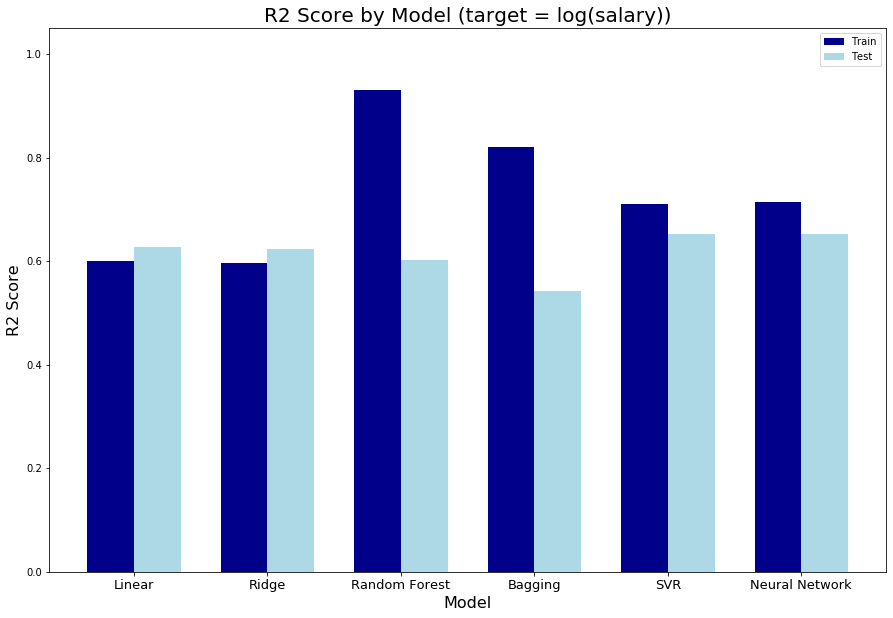

In [531]:
#Model comparison graphs
train_scores = [0.601, 0.596, 0.930, 0.821, 0.710, 0.714]
test_scores = [0.627, 0.623, 0.603, 0.5425, 0.652, 0.652]
N = 6
ind = np.arange(N)  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots(figsize = (15, 10))
rects1 = ax.bar(ind, train_scores, width, color='darkblue')
rects2 = ax.bar(ind + width, test_scores, width, color='lightblue')
ax.set_xlabel('Model', fontsize = 16)
ax.set_ylabel('R2 Score', fontsize = 16)
ax.set_ylim(0, 1.05)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Linear', 'Ridge', 'Random Forest', 'Bagging', 'SVR', 'Neural Network'), fontsize = 13)
ax.set_title('R2 Score by Model (target = log(salary))', fontsize = 20)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'), loc = 'upper right')
print(train_scores)
print(test_scores)

[0.39, 0.387, 0.37, 0.324, 0.368, 0.41]


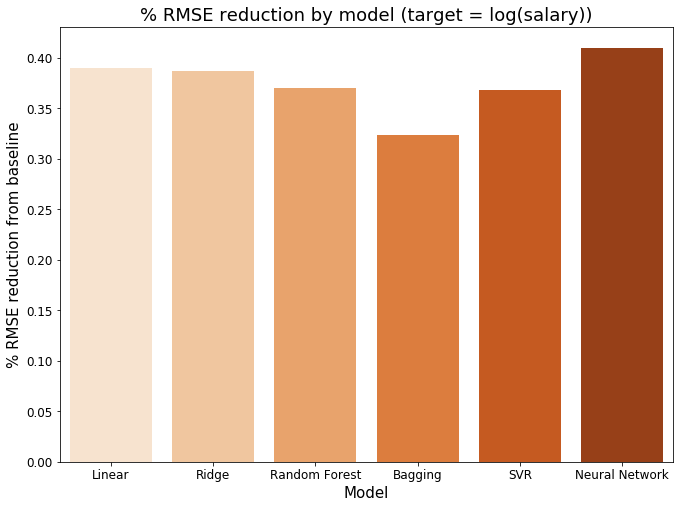

In [565]:
fig, ax = plt.subplots(figsize = (11,8))
ax.set_xlabel('Model', fontsize = 15)
ax.set_ylabel('% RMSE reduction from baseline', fontsize = 15)
ax.tick_params(labelsize = 12)
ax.set_title('% RMSE reduction by model (target = log(salary))', fontsize = 18)
sns.barplot(x = ['Linear', 'Ridge', 'Random Forest', 'Bagging', 'SVR', 'Neural Network'], y = [0.39, 0.387, 0.37, 0.324, 0.368, 0.41], palette = 'Oranges');
print([0.39, 0.387, 0.37, 0.324, 0.368, 0.41])

Performance was generally not very good when using log(salary) as the target and with PCA. The neural network had the best performance slightly outperforming SVR on r2. In terms of RMSE reduction, the neural network was the clear best model. However, the mediocre overall performance led me to attempt the models again with the original target.

[0.792, 0.958, 0.812]
[0.729, 0.743, 0.743]


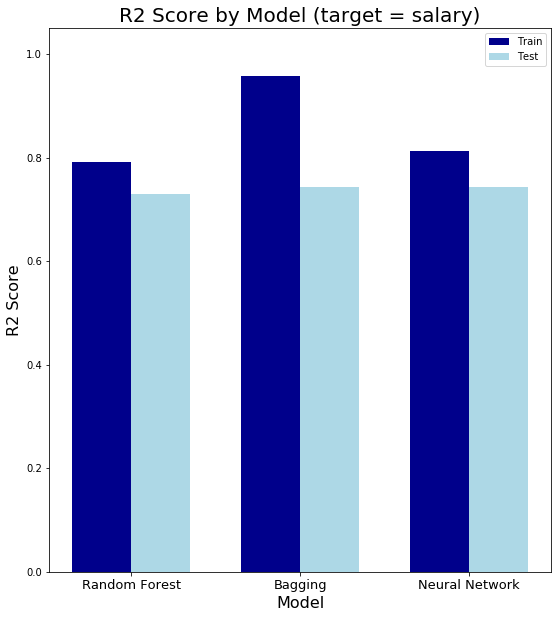

In [590]:
#Model comparison graphs
train_scores = [0.792, 0.958, 0.812]
test_scores = [0.729, 0.743, 0.746]
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots(figsize = (9, 10))
rects1 = ax.bar(ind, train_scores, width, color='darkblue')
rects2 = ax.bar(ind + width, test_scores, width, color='lightblue')
ax.set_xlabel('Model', fontsize = 16)
ax.set_ylabel('R2 Score', fontsize = 16)
ax.set_ylim(0, 1.05)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Random Forest', 'Bagging', 'Neural Network'), fontsize = 13)
ax.set_title('R2 Score by Model (target = salary)', fontsize = 20)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'), loc = 'upper right')
print(train_scores)
print(test_scores)

[0.48, 0.494, 0.494]


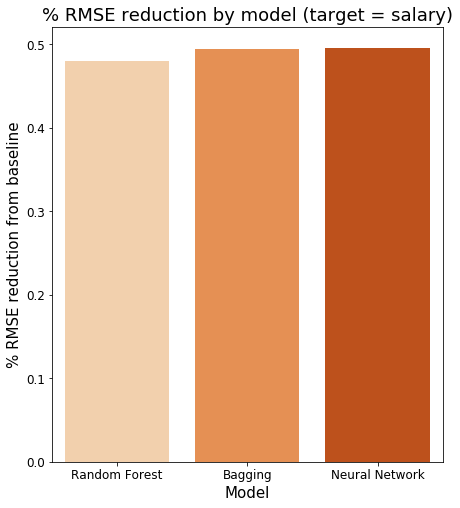

In [591]:
fig, ax = plt.subplots(figsize = (7,8))
ax.set_xlabel('Model', fontsize = 15)
ax.set_ylabel('% RMSE reduction from baseline', fontsize = 15)
ax.tick_params(labelsize = 12)
ax.set_title('% RMSE reduction by model (target = salary)', fontsize = 18)
sns.barplot(x = ['Random Forest', 'Bagging', 'Neural Network'], y = [0.48, 0.494, 0.496], palette = 'Oranges');
print([0.48, 0.494, 0.494])

With the PCA removed and target restored to just the salary, we have restored performance to the original successes seen earlier. The bagging model performed similarly to the neural network in terms of both r2 on the test and RMSE reduction but the neural network had far less overfitting which led to me selecting it as the model to use to make predictions.

In [619]:
resultstest = np.reshape(nn1_testpreds, -1) #to reshape nn predictions for plot

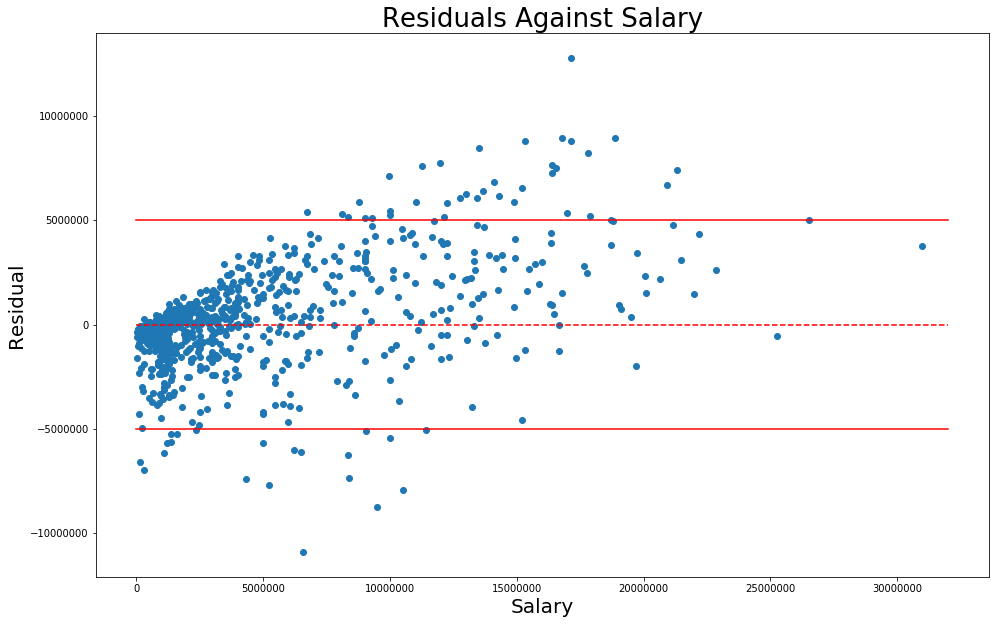

In [620]:
#Residuals plot using final model
plt.figure(figsize=(16,10))

# Calculate residuals.
#residuals = y_train - lr_trainpreds
residuals2 = y_test - resultstest
#residuals = residuals.append(residuals2)
# Generate scatterplot of residuals.
plt.scatter(y_test, residuals2)
# Plot baseline at y=0.
plt.plot((-10,32_000_000),(0,0), color = 'red', linestyle = '--')
plt.plot((-10,32_000_000),(-statsdf['salary'].std(),-statsdf['salary'].std()), color = 'red', linestyle = '-')
plt.plot((-10,32_000_000),(statsdf['salary'].std(),statsdf['salary'].std()), color = 'red', linestyle = '-')

# Set labels and axes.
plt.title("Residuals Against Salary", fontsize=26)
plt.xlabel("Salary", fontsize=20)
plt.ylabel("Residual", fontsize=20)
plt.ticklabel_format(axis = 'both', style = 'plain');

When plotting residuals to actual, we see that the model performed reasonably well with most results residing within the standard error of $5M seen in the EDA. The general trend observed is that the model overvalues players that currently have lower salaries and undervalues superstar type players at higher salaries.

## Conclusion and Recommendations

We were able to create a neural network that had moderate success statistically in predicting salaries based on production. In general, the features with the highest amount of correlation are related to scoring such as points and field goals as well as winshares. Furthermore, there appears to be a premium paid for higher profile athletes that is not related to their production.

The model should sufficiently provide predictions to kick off negotiations at a level that are reasonably close to historical reality. Some limitations are as mentioned in the opening such as length of contract, increasing salary cap considerations as well as rights for some teams to pay more and offer longer term for their own players (Bird rights). Additionally, the model requires many inputs making it cumbersome to use.

Further uses of the model could be for fantasy sports where players are drafted by auction instead of draft pick selection. Values can be better assigned to avoid overpaying a superstar for similar production of another lower profile player.

Next steps include possibly adding in additional historical data since the model is a data hungry one. Furthermore, it seems a modifier is needed to account for "superstar" status as there is a premium paid to these players that isn't production based. Additionally, it could be interesting to put the salaries into bands and turn this into a classification problem. Since the model already performs well as a regression model this could be a better use of the neural network.